# Importy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import plotly.graph_objects as go
import plotly
import random
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual, VBox, HBox

# Algorytmy

In [2]:
def brown_drift_bounce(Y, a, b, vel, mu=1):
    """Two dimentional Brown process with drift on x axis and reflected from 
    a, b on y axis.
    Arguments:
        Y - max y value
        a - min range
        b - max range
        vel - drift velocity
        mu - unit of time [1 s]
    Return:
        B_x - values of Weiner process with drift
        B_y - values of reflected Weiner process""" 
    B_x = [0]
    B_y = [0]
    n = 1
    while B_x[n - 1] < Y:
        r = np.random.normal(loc=0, scale=1)
        next_val_x = B_x[n-1] + np.sqrt(mu)*r
        B_x.append(next_val_x + vel*mu)

        
        r = np.random.normal(loc=0, scale=1)
        next_val_y = B_y[n-1] + np.sqrt(mu)*r
        if next_val_y < a:
            B_y.append(2*a - next_val_y)
        elif next_val_y > b:
            B_y.append(2*b - next_val_y)
        else:
            B_y.append(next_val_y)
        n += 1
    return B_x, B_y

def mpp(l, T):
    """Mixed Poisson process
    Arguments:
        l - one realization of random variable from lambda distribution
        T - time horizon
    Return:
        S - moments of jumps"""
    S = []
    t = 0
    while True:
        U = np.random.uniform()
        t -= 1/l*np.log(U)
        if t > T:
            return S
        S.append(t)


def theta_proces(Z_dist = "Normal", a=1, V_dist="Normal", A=0, B=1, drunk_vel=1, max_x=1000, h=1):
    """Function to simulate theta process. 
    Arguments:
        Z_dist - first distribution for theta process
        a - parameter for Z distribution
        V_dist - second distribution for theta process
        A, B - parameters for V_distribution
        drunk_vel - drive velocity
        max_x - end the process when this value is reached
    Return:
        x and y trajectories of theta process"""

    tr_x = [0]
    tr_y = [0]
    theta = 0
    y_min = 0
    y_max = 50
    if Z_dist == "Normal":
        Z_gen = np.random.normal
    elif Z_dist == "Uniform":
        Z_gen = np.random.uniform

    if V_dist == "Normal":
        V_gen = np.random.normal
    elif V_dist == "Uniform":
        V_gen = np.random.uniform
    elif V_dist == "LogNorm":
        V_gen = np.random.lognormal

    while tr_x[-1] < max_x:
        if Z_dist == "Expon":
            theta += np.sqrt(h)*np.random.exponential(a)
        else:
            theta += Z_gen(0, a)
        if V_dist == "Expon":
            tr_x.append(tr_x[-1] + np.sqrt(h)*np.random.exponential(A)*np.cos(theta) + drunk_vel * h)
            new_y = tr_y[-1] + np.sqrt(h)*np.random.exponential(A)*np.sin(theta)

            
        else:
            tr_x.append(tr_x[-1] + np.sqrt(h)*V_gen(A, B)*np.cos(theta) + drunk_vel * h)
            new_y = tr_y[-1] + np.sqrt(h)*V_gen(A, B)*np.sin(theta)

        if new_y > y_max:
            tr_y.append(2*y_max - new_y)
        elif new_y < y_min:
            tr_y.append(2*y_min - new_y)
        else:
            tr_y.append(new_y)

    return tr_x, tr_y

def nie_pois_proc(l_fun, T ,n=1000):
    """returns IPP jumps"""
    k = np.linspace(0, T, n)
    M = max(l_fun(k))
    t = 0
    S = []
    while True:
        U1 = random.random()
        t -= (1/M)*np.log(U1)
        if t > T:
            break
        U2 = random.random()
        if U2 <= l_fun(t)/M:
            S.append(t)
    return S


def poison_proc(l, T):
    n = np.random.poisson(T*l)
    if n == 0:
        return []
    U = [T*random.random() for i in range(n)]
    U.sort()
    return U

l = [lambda t: np.sin(t)**2, lambda t: np.exp(-t**2), lambda t: t, lambda t: np.sign(np.sin(np.pi*t)) + 1, lambda t: np.exp((2*np.sin(t/12 + 3) - 0.9)**3)]


Poniżej znajduje się nasza implementacja i interpretacja problemu Pijak. Postanowiłyśmy stworzyć trzy klasy: klase pijaka, samochodu oraz ulicy. 

# Klasa Pijak

Klasa Drunk zawiera przede wszystkim trajektorie pijaka. Trajektoria pijaka to domyślnie odbity ruch Browna z dryfem, albo proces $(X_t, Y_t)$, gdzie $$X_{t_{i+1}} = X_{t_i} + \sqrt{t_{i+1}+ t_1}V_i \cos{\Theta_{t_i}},$$
$$Y_{t_{i+1}} = Y_{t_i} + \sqrt{t_{i+1}+ t_1}V_i \sin{\Theta_{t_i}},$$
z kolei $\Theta_{t_{i+1}} = \Theta_{t_{i}} + \sqrt{t_{i+1}+ t_1}Z_i$, 

$Z_i \sim N(0,a), U(0,a), Exp(a),$

$V_i \sim N(A,B), U(A,B), Exp(A), LogN(A,B).$

In [3]:
class Drunk():
    """Class of drunk"""
    def __init__(self, vel=1, theta = False, Z_dist = "Normal", a=1, V_dist="Normal", A=0, B=1):
        """Arguments (optional):
            vel - velocity of the drunk (1)
            theta - if True the movement would come from theta process not Brown (False)
            Z_dist - first distribution for theta process
            a - parameter for Z distribution
            V_dist - second distribution for theta process
            A, B - parameters for V_distribution
        Initialize:
            self.x - x of the drunk's position as 0
            self.y - y of the drunk's position as 0
            self.vel - drive value of the drunk as vel
            self.tr_x, self.tr_y - brown or theta process trjectories
             """ 
        self.x = 0
        self.y = 0
        self.vel = vel
        if theta:
            self.tr_x, self.tr_y = theta_proces(drunk_vel = self.vel, Z_dist=Z_dist, a=a, V_dist=V_dist, A=A, B=B)
        else:
            self.tr_x, self.tr_y = brown_drift_bounce(1000, 0, 50, self.vel)

# Klasa samochód

Klasa Car zawiera podstawowe informacje o samochodach, między innymi o ich położeniu i prędkości.

In [4]:
class Car():
    """Class of cars"""
    def __init__(self, pos, t, d=10, vel=10**4):
        """Arguments:
            pos - "left" or "right" value (which way the car goes)
            t - current time
            d - width of the road
            vel - velocity of the car
        Initialize:
            self.vel - velocity of the car as vel
            self.x - x of car's position as -5 or 1005
            self.y - y of car's position 
            self.direction - direction of the car (1 : --->; -1 : <-----)
            self.start_time - as t"""
        self.vel = vel
        if pos == "left":
            self.x = -5
            self.y = 25 + d/2
            self.direction = 1
        else:
            self.x = 1005
            self.y = 25 - d/2
            self.direction = -1
        self.start_time = t

    def update_pos(self):
        """Move car by it's velocity towards the correct direction"""
        self.x += self.vel * self.direction

# Klasa ulica

Ostatnia klasa Street łączy w sobie dwie poprzednie. To tutaj dodajemy auta i pijaka na ulice, a następnie poruszamy nimi tak długo, aż pijak zginie lub dotrze na miejsce.
Jako jednostkę czasu przyjełyśmy 1 sekundę. Z wiązku z tym trajektoria pijaka nie jest tak naprawdę ciągła, co więcej istnieje możliwość, że pijak i samochód zderzą się w momencie, w którym nie znamy ich dokładnego położenia, przez to nie wykryjemy takich kolizji. Aczkolwiek niezależnie od wyboru jednostki czasu problem ten będzie występować, tylko w mniejszym bądź większym stopniu. Na szczęście ruchy pijaka są na tyle małe w porównaniu z wielkością samochodów, że możymy pominąć ten problem, bez większych zmian we wnioskach.    

In [5]:
class Street():
    def __init__(self, d, v_m, v_M):
        """Arguments:
            d - width of the road
            v_m - minimum of the cars' velocities
            v_M - maximum of the cars' velocities
        Initialize:
            self.d - width of the road as d
            self.v_m - as v_m
            self.v_M - as v_M
            self.t - clock as 0
            self.cars_r_wait - list of times of arrival of cars waiting to enter
                the right going lane as an empty list
            self.cars_l_wait - list of times of arrival of cars waiting to enter
                the left going lane as an empty list
            self.cars_on_r_lane - list of car objects on right lane as en empty list
            self.cars_on_l_lane - list of car objects on the left lane as en empty list"""
        self.d = d
        self.v_m = v_m
        self.v_M = v_M

        self.t = 0

        self.cars_r_wait = []
        self.cars_l_wait = []
        self.cars_on_r_lane = []
        self.cars_on_l_lane = []

    def generate_cars_left(self, l, l_appear='mmp'):
        """Saves realization of correct type of poisson process to self.left_cars
        variable
        Arguments:
            l - realization of random variable
            l_appear - "mmp" - mixed poisson process, "jpp" - poisson process, 
                or "npp" - non homogeus poisson process"""
            
        if l_appear=='mmp':
            self.left_cars = mpp(l, self.T) # l - jedna realizacja zmiennej losowej
        elif l_appear=='jpp': 
            self.left_cars = poison_proc(l, self.T)
        elif l_appear=='npp':
            self.left_cars = nie_pois_proc(l, self.T, n=100)

    def generate_cars_right(self, l, r_appear='mmp'): 
        """Saves realization of correct type of poisson process to self.right_cars
        variable
        Arguments:
            l - realization of random variable
            l_appear - "mmp" - mixed poisson process, "jpp" - poisson process, 
                or "npp" - non homogeus poisson process"""
        if r_appear=='mmp':
            self.right_cars = mpp(l, self.T) # l - jedna realizacja zmiennej losowej
        elif r_appear=='jpp':
            self.right_cars = poison_proc(l, self.T)
        elif r_appear=='npp':
            self.right_cars = nie_pois_proc(l, self.T, n=100)

    def get_vel_min_l(self):
        """Return mimimum value of the velocities of cars on the left lane of v_M"""
        return np.min([i.vel for i in self.cars_on_l_lane], initial=self.v_M)

    def get_vel_min_r(self):
        """Return mimimum value of the velocities of cars on the right lane of v_M"""
        return np.min([i.vel for i in self.cars_on_r_lane], initial=self.v_M)
    
    def put_drunk(self, drunk):
        """Sets self.drunk as drunk and the maximum end time as self.T
        Arguments:
            drunk - an object of drunk class"""
        
        self.drunk = drunk
        self.T = len(self.drunk.tr_x)

    def hit_by_car(self):
        """Return:
            1 if the drunk is hit by a car
            O otherwise"""
        if  25 - self.d/2 - 2.5 <= self.drunk.tr_y[self.t] <= 25 - self.d/2 + 2.5:
            for car_r in self.cars_on_r_lane:
                if car_r.x -5 <= self.drunk.tr_x[self.t] <= car_r.x + 5:
                    return 1
        if  25 + self.d/2 - 2.5 <= self.drunk.tr_y[self.t] <= 25 + self.d/2 + 2.5:
            for car_l in self.cars_on_l_lane:
                if car_l.x -5 <= self.drunk.tr_x[self.t] <= car_l.x + 5:
                    return 1
        return 0
    
    def step(self): 
        """Main function to simulate single 'round' (second). In this function - 
        cars are moved, added and removed and the potential collisions are checked."""
        # dodawanie aut
        # lewa strona
        if len(self.left_cars) != 0 and self.left_cars[0] <= self.t + 1: # sprawdzamy czy w tej sekundzie dodajemy samochód, albo czy mamy jakieś zaległe do dodania
            s_t = self.left_cars.pop(0)  # usuwamy z listy czas auta który dodajemy
            self.cars_l_wait.append(s_t) # dodajemy je do kolejki

            # sprawdzamy czy możemy dodać auto z listy oczekujących
            if len(self.cars_on_l_lane) == 0 or self.cars_on_l_lane[-1].x > 20:  # nie ma aut na drodze lub są odpowiednio daleko
                #assignment of velocity
                car_vel = np.random.uniform(self.v_m, self.get_vel_min_l())
                car = Car("left", self.cars_l_wait[0], self.d, car_vel)
                self.cars_on_l_lane.append(car) # dodajemy auto na jezdnie


        # prawa strona
        if len(self.right_cars) != 0 and self.right_cars[0] <= self.t + 1: # sprawdzamy czy w tej sekundzie dodajemy samochód, albo czy mamy jakieś zaległe do dodania
            s_t = self.right_cars.pop(0)  # usuwamy z listy czas auta który dodajemy
            self.cars_r_wait.append(s_t) # dodajemy je do kolejki

            # sprawdzamy czy możemy dodać auto z listy oczekujących
            if len(self.cars_on_r_lane) == 0 or self.cars_on_r_lane[-1].x < 980:  # nie ma aut na drodze lub są odpowiednio daleko
                #assignment of velocity
                car_vel = np.random.uniform(self.v_m, self.get_vel_min_r())
                car = Car("right", self.cars_r_wait, self.d, car_vel)
                self.cars_on_r_lane.append(car) # dodajemy auto na jezdnie


        #remove cars
        for (i, car) in enumerate(self.cars_on_l_lane):
            car.update_pos() # move cars
            if car.x > 1005:
                self.cars_on_l_lane.pop(i)

        for (i, car) in enumerate(self.cars_on_r_lane):
            car.update_pos() # move cars
            if car.x < -5:
                self.cars_on_r_lane.pop(i)

        # zderzenie z pijakiem
        if self.hit_by_car():
            temp = self.t
            self.t = self.T
            return temp


        self.t += 1

# Symulacja

In [6]:
def simulate(drunk, v_m=8.333, v_M=16.666, d=10, l1=np.random.exponential(0.03), l2=np.random.exponential(0.03)):
    """Arguments:
        drunk - object of the Drunk class
        v_m - mimimum velocity of the cars
        v_M - maximum velocity of the cars
        d - width of the road
        l1, l2 - random variable for the poisson process
    Return:
        list of lists of cars in every second."""
    cars = []
    street = Street(d, v_m, v_M)
    street.put_drunk(drunk)
    street.generate_cars_left(l1)
    street.generate_cars_right(l2)
    while street.t < street.T:
        street.step()
        cars.append([copy.copy(car) for car in street.cars_on_l_lane + street.cars_on_r_lane])
    return cars

In [7]:
def make_anim(cars, drunk):
    """Prepare animation in plotly.
    Arguments:
        cars - list of lists of cars in every second
        drunk - an object of the Drunk class
    Return:
        fig object that holds frames for the animation"""
    frames = [go.Frame()]
    for i in range(len(cars)):
        plot_cars = []
        x_cars = [None]
        y_cars = [None]
        for car in cars[i]:
            x_cars += [car.x-5, car.x-5, car.x+5, car.x+5, car.x -5, None] 
            y_cars += [car.y-2.5,car.y+2.5,car.y+2.5, car.y-2.5, car.y - 2.5, None]
        pijak = go.Scatter(x = [drunk.tr_x[i]], y = [drunk.tr_y[i]])
        button = {
            "type": "buttons",
            "buttons": [
                {
                    "label": "Play",
                    "method": "animate",
                    "args": [None, {"frame": {"duration": 20}}],
                }
            ],
        }
        # add the button to the layout and update the 
        layout = go.Layout(updatemenus=[button])
        # create a frame object
        frame = go.Frame(
            data=[go.Scatter(x=x_cars, y=y_cars, fill="toself"), pijak],
            layout=layout)
        
        frames.append(frame)


    fig = go.Figure(data=[go.Scatter(x=x_cars, y=y_cars, fill="toself"), pijak],
                    frames=frames,
                    layout=layout
    )
    fig.update_xaxes(range=(0,1000))
    fig.update_yaxes(range=(0,50))
    return fig

In [ ]:
def init_layout():
    def on_button_clicked(b):
        d = d_slider.value
        v_m, v_M = car_v_slider.value
        drunk_vel = drunk_v_slider.value
        Nt_val = get_value(Nt.value, Nt_data)
        Mt_val = get_value(Mt.value, Mt_data)
        if Brown_or_theta.value == "Brown":
            drunk = Drunk(drunk_vel)
        else:
            theta = True
            Z_gen = Z_gen_choice.value
            V_gen = V_gen_choice.value
            a = a_slider.value
            if len(Vgen_data) == 1:
                A = Vgen_data[0].value
                B = 1
            else:
                A = Vgen_data[0].value
                B = Vgen_data[1].value

            drunk = Drunk(vel=drunk_vel, Z_dist=Z_gen, a=a, V_dist=V_gen, A=A, B=B)

        cars = simulate(drunk, v_m, v_M, d, Nt_val, Mt_val)

        print("animation in progress...")
        all_widgets.close()
        global fig
        fig = make_anim(cars, drunk)
        if save_anim.value:
            fig.write_html("Animacja.html")
        fig.show()
        reset_button.on_click(on_reset)
        display(reset_button)

    def on_reset(b):
        clear_output()
        init_layout()
    def create_slider(if_range = True, min=0, max=0.5, step=0.01, min2=0, max2=1, ver="Nt"):
        if if_range:
            slider =  widgets.FloatSlider(
                value=(min + max)/2,
                min=min,
                max=max,
                step=0.01,
                description=ver + ' param 1',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.2f',
                style=style,
            )
            slider_2 =  widgets.FloatSlider(
                value=(min2 + max2)/2,
                min=min2,
                max=max2,
                step=0.01,
                description=ver +' param 2',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.2f',
                style=style,
            )

            return slider, slider_2

        else:
            slider =  widgets.FloatSlider(
                value=(min + max)/2,
                min=min,
                max=max,
                step=step,
                description= ver +' parameter',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.2f',
                style=style,
            )
            return [slider]

    

    def Nt_handler(change):
        """Handle events of toggled Nt RadioButtons"""
        global Nt_data
        for i in Nt_data:
            i.close()
        new = Nt.value
        if new == "Normal" or new == "Uniform":
            Nt_data = create_slider()
        else:
            Nt_data = create_slider(if_range=False)
        Nt_VBox.children = [Nt, *Nt_data]

    def Mt_handler(change):
        """Handle events of toggled Mt RadioButtons"""
        global Mt_data
        for i in Mt_data:
            i.close()
        new = Mt.value
        if new == "Normal" or new == "Uniform":
            Mt_data = create_slider(ver="Mt")
        else:
            Mt_data = create_slider(if_range=False, ver="Mt")
        Mt_VBox.children = [Mt, *Mt_data]

    def V_gen_choice_handler(change):
        """Handle events of toggled V_gen_choice RadioButtons"""
        global Vgen_data
        for i in Vgen_data:
            i.close()
        new = V_gen_choice.value
        if new == "Normal" or new == "Uniform" or new=="LogNormal":
            Vgen_data = create_slider(ver="V gen")
        else:
            Vgen_data = create_slider(if_range=False, ver="V gen")
        Vgen_VBox.children = Vgen_data

    def get_value(val, data):

        if val == "Exponential":
            return np.random.exponential(data[0].value)
        elif val == "Normal":
            return np.random.normal(*[i.value for i in data])
        elif val == "Uniform":
            return np.random.uniform(*[i.value for i in data])

    def choose_process_handler(change):
        global theta_widgets
        new = Brown_or_theta.value
        if new == "Brown":
            theta_VBox.children = [Brown_or_theta]
        else:
            theta_widgets = create_theta_widgets()
            theta_VBox.children = [Brown_or_theta, *theta_widgets]

    def create_theta_widgets():
        global Vgen_data
        global Vgen_VBox
        global V_gen_choice
        global a_slider
        global Z_gen_choice

        Z_gen_choice = widgets.RadioButtons(
            options=['Normal', 'Uniform', 'Expon'],
            value='Normal', # Defaults to 'pineapple'
            layout={'width': 'max-content'}, # If the items' names are long
            description='Choice of Z gen',
            disabled=False,
            style = {'description_width': 'initial'}
        )
        a_slider = widgets.FloatSlider(
            value=2,
            min=0.1,
            max=15,
            step=0.1,
            description='a',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
            )
        V_gen_choice = widgets.RadioButtons(
            options=['Normal', 'Uniform', 'Expon', 'LogNorm'],
            value='Normal', # Defaults to 'pineapple'
            layout={'width': 'max-content'}, # If the items' names are long
            description='Choice of V gen',
            disabled=False,
            style = {'description_width': 'initial'}
            )
        
        Vgen_data = create_slider(if_range=True, ver="V gen: ")
        Vgen_VBox = VBox([*Vgen_data])
        
        V_gen_choice.observe(handler=V_gen_choice_handler)


        return Z_gen_choice, a_slider, V_gen_choice, Vgen_VBox

    style = {'description_width': 'initial'}

    d_slider = widgets.FloatSlider(
        value=10,
        min=5,
        max=15,
        step=0.1,
        description='d',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        style=style, 
    )

    drunk_v_slider = widgets.FloatSlider(
        value=1,
        min=0.5,
        max=2,
        step=0.1,
        description='Drunk velocity :',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        style=style, 
    )

    car_v_slider = widgets.FloatRangeSlider(
        min=0.5,
        max=20,
        step=0.1,
        description='Car velocity range : ',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        style=style, 
    )


    Nt = widgets.RadioButtons(
        options=['Exponential', 'Normal', 'Uniform'],
        value='Exponential',
        layout={'width': 'max-content'}, # If the items' names are long
        description='Nt',
        disabled=False
    )

    Mt = widgets.RadioButtons(
        options=['Exponential', 'Normal', 'Uniform'],
        value='Exponential',
        layout={'width': 'max-content'}, # If the items' names are long
        description='Mt',
        disabled=False
    )

    Brown_or_theta = widgets.RadioButtons(
        options=['Brown', 'Theta'],
        value='Brown', # Defaults to 'Brown'
        layout={'width': 'max-content'}, # If the items' names are long
        description='Process:',
        disabled=False
    )

    save_anim = widgets.Checkbox(
        value=False,
        description='Save animation to .gif',
        disabled=False,
        indent=False
    )

    anim_button = widgets.Button(
        value=False,
        description='Make animation',
        disabled=False,
        button_style='',
        tooltip='Description',
        icon=''
    )

    reset_button = widgets.Button(
        value=False,
        description='Reset',
        disabled=False,
        button_style='',
        tooltip='Description',
        icon=''
    )


    global Nt_data, Mt_data
    Nt_data = create_slider(if_range=False)
    Mt_data = create_slider(if_range=False, ver="Mt")
    Nt_VBox = VBox([Nt, *Nt_data])
    Mt_VBox = VBox([Mt, *Mt_data])
    theta_VBox = VBox([Brown_or_theta])
    VBox1 = VBox([d_slider, drunk_v_slider, car_v_slider, Nt_VBox, Mt_VBox, save_anim, anim_button])
    all_widgets = HBox([VBox1,theta_VBox])
    Nt.observe(handler=Nt_handler)
    Mt.observe(handler=Mt_handler)
    Brown_or_theta.observe(handler=choose_process_handler)
    anim_button.on_click(on_button_clicked)
    display(all_widgets)

In [ ]:
init_layout()

# Analiza prawdopodobieństwa

Poniższe wykresy prezentują prawdopodobieństwo śmierci pijaka w zależności od różnych zmiennych i parametrów. Heatmapy ukazują rozkład czasów śmierci pijaka.


In [8]:
def probability(n, d=10, Nt=np.random.exponential(0.03), Mt=np.random.exponential(0.03), v_m=8.333 , v_M=13.8888, 
                vel=1, l_appear='mmp', r_appear='mmp' ): 
    """Arguments:
    n - number of simulations,
    d - width of the road
    Nt, Mt - random variable for the poisson process
    v_m - minimum of the cars velocities
    v_M - maximum of the cars velocities
    vel - drunk velocity
    l_appear - type of process for cars appearing on the left
    r_appear - type of process for cars appearing on the right
    Return: 
    times - list of moments of death
    dead/n - probability of death in n trials
    """
    dead = 0
    times = []
    for i in range(n):
        street = Street(d, v_m, v_M)
        street.put_drunk(Drunk(vel))
        street.generate_cars_left(Nt, l_appear=l_appear)
        street.generate_cars_right(Mt, r_appear=r_appear)
        while street.t < street.T:
            a = street.step()
            if a:
                dead += 1
                times.append(a)
    return times, dead/n

In [9]:
def make_heatmap(times, param):
    data = np.zeros((len(times), 10))
    bin_vals = np.histogram([val for i in times for val in i], bins=10)
    for val, i in enumerate(times):
        data[val-1, :] = np.histogram(i, bins=bin_vals[1])[0]
    sns.heatmap(data, yticklabels=param, xticklabels=False)
    plt.show()

Prawdopodobieństwo śmierci pijaka w zależności od szerokości ulicy d dla 1000 prób Monte Carlo.



In [10]:
data = [probability(1000, d=i) for i in np.linspace(5, 15, 10)]

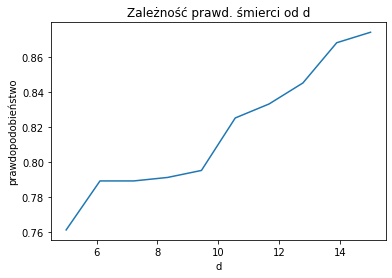

In [13]:
times = [i[0] for i in data]
prob = [i[1] for i in data]
plt.plot(np.linspace(5, 15, 10), prob)
plt.title("Zależność prawd. śmierci od d")
plt.xlabel("d")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych wielkości d


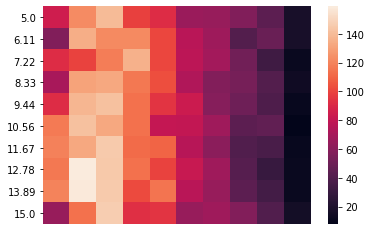

In [14]:
print("Heatmapa momentów śmierci dla różnych wielkości d")
make_heatmap(times, np.round(np.linspace(5, 15, 10),2))

**Wnioski**

Prawdopodobieństwo śmierci pijaka rośnie wraz ze wzrostem szerokości ulicy.

Prawdopodobieństwo śmierci pijaka w zależności od prędkości pijaka dla 1000 prób Monte Carlo.





In [15]:
data2 = [probability(1000, vel=i) for i in np.linspace(0.5, 2, 10)]

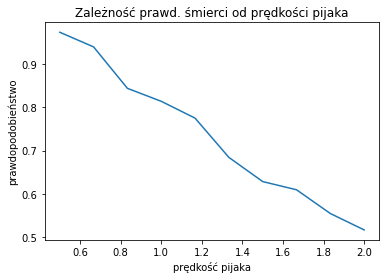

In [16]:
times2 = [i[0] for i in data2]
prob = [i[1] for i in data2]
plt.plot(np.linspace(0.5, 2, 10), prob)
plt.title("Zależność prawd. śmierci od prędkości pijaka")
plt.xlabel("prędkość pijaka")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych prędkości pijaka


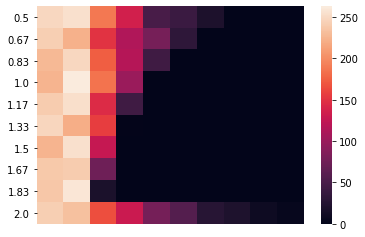

In [17]:
print("Heatmapa momentów śmierci dla różnych prędkości pijaka")
make_heatmap(times2, np.round(np.linspace(0.5, 2, 10),2))

**Wnioski**

Prawdopodobieństwo śmierci pijaka maleje wraz ze wzrostem jego prędkości.

Prawdopodobieństwo śmierci pijaka w zależności od prędkości samochodów dla 1000 prób Monte Carlo


In [18]:
vel_prob1 = [probability(1000, v_m = i , v_M = 13.8888) for i in np.linspace(0.5, 12, 13, endpoint=True)]  #50 km/h = 13.8888 m/s

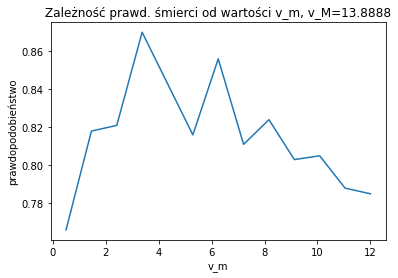

In [19]:
time = [i[0] for i in vel_prob1]
prob = [i[1] for i in vel_prob1]
plt.plot(np.linspace(0.5, 12, 13, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od wartości v_m, v_M=13.8888")
plt.xlabel("v_m")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych v_m, v_M=13.8888


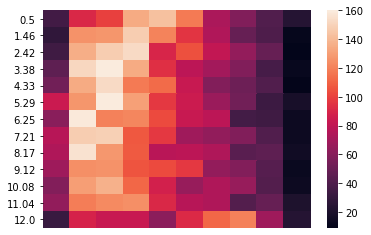

In [22]:
print("Heatmapa momentów śmierci dla różnych v_m, v_M=13.8888")
make_heatmap(time, np.round(np.linspace(0.5, 12, 13, endpoint=True),2))

In [23]:
vel_prob2 = [probability(1000, v_m = 0.5 , v_M = i) for i in np.linspace(1, 13.8888, 13, endpoint=True)]

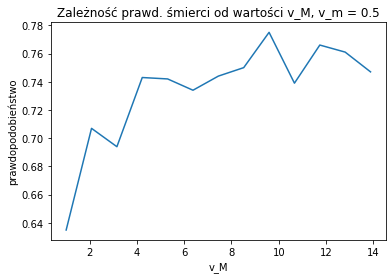

In [24]:
time = [i[0] for i in vel_prob2]
prob = [i[1] for i in vel_prob2]
plt.plot(np.linspace(1, 13.8888, 13, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od wartości v_M, v_m = 0.5")
plt.xlabel("v_M")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych v_M, v_m = 0.5


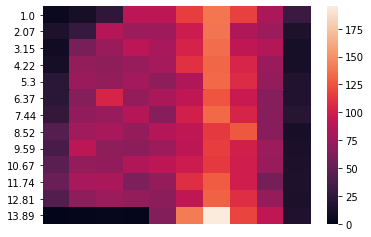

In [25]:
print("Heatmapa momentów śmierci dla różnych v_M, v_m = 0.5")
make_heatmap(time, np.round(np.linspace(1, 13.8888, 13, endpoint=True),2))

**Wnioski**

Prawdopodobieństwo śmierci pijaka maleje, gdy zakres prędkości zawęża się w górnej granicy, natomiast rośnie, gdy zakres prędkości samochodów rozszerza się.

Prawdopodobieństwo w zależności od rozkładów Nt i Mt


In [26]:
def probability2(n, d=10, fun1=np.random.exponential(0.03), fun2=np.random.exponential(0.03), v_m=1.3888 , v_M=13.8888 ,
                 vel=1, l_appear='mmp', r_appear='mmp' ):
    """Arguments:
    n - number of simulations,
    d - width of the road
    fun1, fun2 - random variable for the poisson process
    v_m - minimum of the cars velocities
    v_M - maximum of the cars velocities
    vel - drunk velocity
    l_appear - type of process for cars appearing on the left
    r_appear - type of process for cars appearing on the right
    Return: 
    times - list of moments of death
    dead/n - probability of death in n trials
    """
    dead = 0
    times = []
    for i in range(n):
        Nt = fun1
        Mt = fun2
        street = Street(d, v_m, v_M)
        street.put_drunk(Drunk(vel))
        street.generate_cars_left(Nt, l_appear=l_appear)
        street.generate_cars_right(Mt, r_appear=r_appear)
        while street.t < street.T:
            a = street.step()
            if a:
                dead += 1
                times.append(a)
    return times, dead/n

Auta pojawiają się zgodnie z jednorodnym procesem Poissona z int. l

Zależność prawdopodobieństwa śmierci od parametru int. l dla samochodów jadących z lewej strony dla 500 prób Monte Carlo. Parametr intensywności dla aut pojawiających się z prawej strony wynosi 0.05.

In [27]:
d1 = [probability2(500, fun1=i, fun2=0.05, l_appear='jpp', r_appear='jpp') for i in np.linspace(0.01, 0.8, 10, endpoint=True)] 

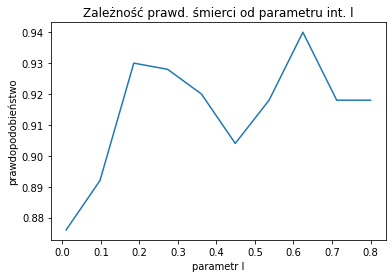

In [28]:
t1 = [i[0] for i in d1]
prob = [i[1] for i in d1]
plt.plot(np.linspace(0.01, 0.8, 10, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru int. l")
plt.xlabel("parametr l")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów l


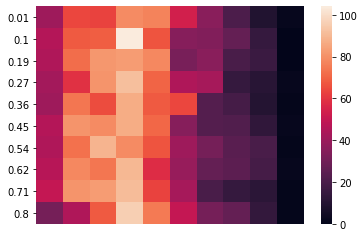

In [29]:
print("Heatmapa momentów śmierci dla różnych parametrów l")
make_heatmap(t1, np.round(np.linspace(0.01, 0.8, 10, endpoint=True),2))

Zależność prawdopodobieństwa śmierci od parametru int. l dla samochodów jadących z prawej strony dla 500 prób Monte Carlo. Parametr intensywności dla aut pojawiających się z lewej strony wynosi 0,05.

In [30]:
d2 = [probability2(500, fun1=0.05, fun2=i, l_appear='jpp', r_appear='jpp') for i in np.linspace(0.01, 0.8, 10, endpoint=True)] 

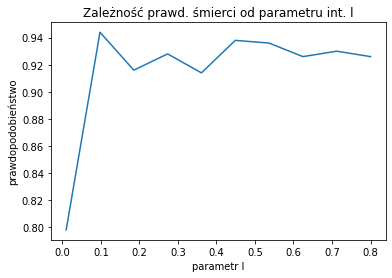

In [31]:
t2 = [i[0] for i in d2]
prob = [i[1] for i in d2]
plt.plot(np.linspace(0.01, 0.8, 10, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru int. l")
plt.xlabel("parametr l")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów l


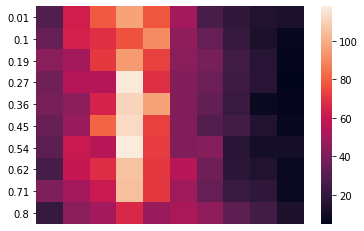

In [32]:
print("Heatmapa momentów śmierci dla różnych parametrów l")
make_heatmap(t2, np.round(np.linspace(0.01, 0.8, 10, endpoint=True),2))

**Wnioski**

Prawdopodobieństwo śmierci pijaka jest bardzo wysokie (ok. 90%), gdy auta pojawiają się zgodnie z jednorodnym procesem Poissona.

Auta jadące z lewej strony pojawiają się zgodnie z jednorodnym procesem Poissona, natomiast auta jadące z prawej strony pojawiają się zgodnie z mieszanym procesem Poissona.

Zależność prawdopodobieństwa śmierci od parametru int. l dla samochodów jadących z lewej strony dla 500 prób Monte Carlo. Zmienną mieszającą dla aut pojawiających się z prawej strony jest zmienna losowa z rozkładu wykładniczego z parametrem 0,03.

In [33]:
d3 = [probability2(500, fun1=i, l_appear='jpp') for i in np.linspace(0.01, 0.8, 10, endpoint=True)] 

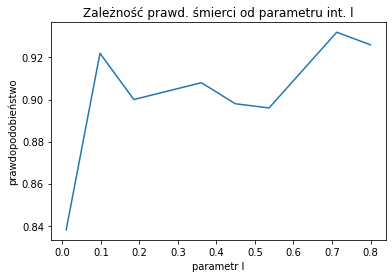

In [34]:
t3 = [i[0] for i in d3]
prob = [i[1] for i in d3]
plt.plot(np.linspace(0.01, 0.8, 10, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru int. l")
plt.xlabel("parametr l")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów l


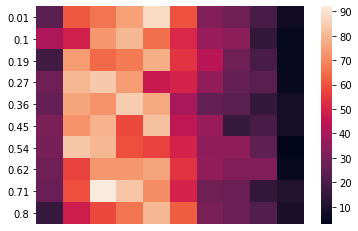

In [35]:
print("Heatmapa momentów śmierci dla różnych parametrów l")
make_heatmap(t3, np.round(np.linspace(0.01, 0.8, 10, endpoint=True),2))

**Wnioski**

Prawdopodobieństwo śmierci pijaka gwałtownie rośnie wraz ze wzrostem parametru intensywności i stabilizuje się w okolicach 70%.

Auta jadące z lewej strony pojawiają się zgodnie z jednorodnym procesem Poissona, natomiast auta jadące z prawej strony pojawiają się zgodnie z niejednorodnym procesem Poissona z funkcją intensywności $f(t) = \exp(-t^2)$.

Zależność prawdopodobieństwa śmierci od parametru int. l dla samochodów jadących z lewej strony dla 500 prób Monte Carlo.

In [36]:
d4 = [probability2(500, fun1=i, fun2=l[1], l_appear='jpp', r_appear='npp') for i in np.linspace(0.01, 0.8, 10, endpoint=True)] 

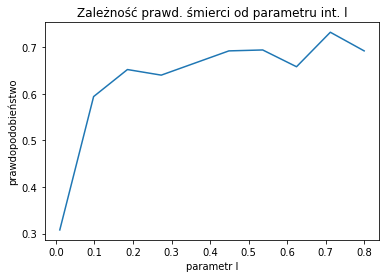

In [37]:
t4 = [i[0] for i in d4]
prob = [i[1] for i in d4]
plt.plot(np.linspace(0.01, 0.8, 10, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru int. l")
plt.xlabel("parametr l")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów l


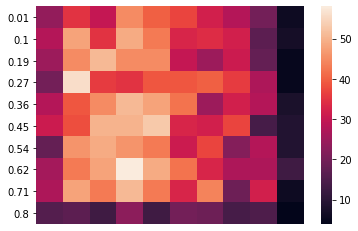

In [38]:
print("Heatmapa momentów śmierci dla różnych parametrów l")
make_heatmap(t4, np.round(np.linspace(0.01, 0.8, 10, endpoint=True),2))

**Wnioski**

W tym przypadku prawdopodobieństwo śmierci pijaka gwałtownie rośnie wraz ze wzrostem parametru intensywności i utrzymuje się w okolicach 70%.

Zależność prawdopodobieństwa śmierci od zmiennej mieszającej mieszanego procesu Poissona.





Auta pojawiają się zgodnie z mieszanym procesem Poissona ze zmienną mieszającą z rozkładu wykładniczego.

In [39]:
data3 = [probability2(500, fun1=np.random.exponential(i)) for i in np.linspace(0.01, 0.8, 10, endpoint=True)]
data4 = [probability2(500, fun2=np.random.exponential(i)) for i in np.linspace(0.01, 0.8, 10, endpoint=True)]

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej aut jadących z lewej strony dla 500 prób Monte Carlo. Zmienna mieszająca dla aut jadących z prawej strony pochodzi z rozkładu $Exp(0.03)$.

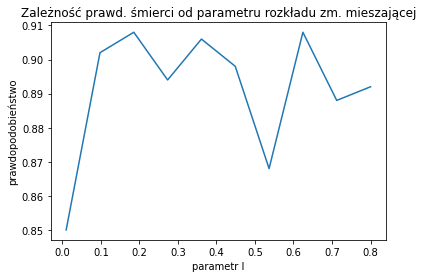

In [40]:
times3 = [i[0] for i in data3]
prob = [i[1] for i in data3]
plt.plot(np.linspace(0.01, 0.8, 10, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru rozkładu zm. mieszającej")
plt.xlabel("parametr l")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów l


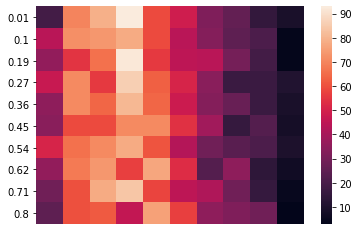

In [41]:
print("Heatmapa momentów śmierci dla różnych parametrów l")
make_heatmap(times3, np.round(np.linspace(0.01, 0.8, 10, endpoint=True),2))

**Wnioski**

Prawdopodobieństwo śmierci pijaka rośnie wraz ze wzrostem parametru rozkładu i stabilizuje się w okolicach 80%.

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej aut jadących z prawej strony dla 500 prób Monte Carlo. Zmienna mieszająca dla aut jadących z lewej strony pochodzi z rozkładu $Exp(0.03)$.



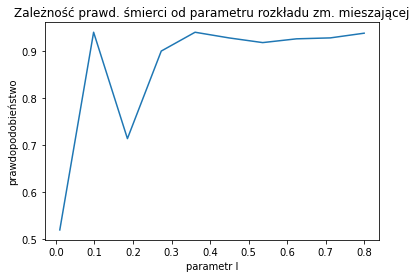

In [42]:
times4 = [i[0] for i in data4]
prob = [i[1] for i in data4]
plt.plot(np.linspace(0.01, 0.8, 10, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru rozkładu zm. mieszającej")
plt.xlabel("parametr l")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów l


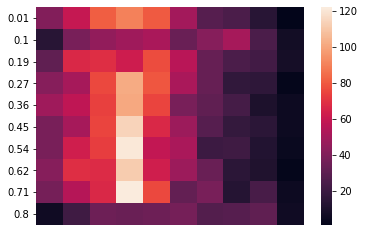

In [43]:
print("Heatmapa momentów śmierci dla różnych parametrów l")
make_heatmap(times4, np.round(np.linspace(0.01, 0.8, 10, endpoint=True),2))

**Wnioski**

Prawdopodobieństwo śmierci pijaka rośnie wraz ze wzrostem parametru rozkładu zmiennej mieszającej i stabilizuje się w okolicach 90%.

Auta pojawiają się zgodnie z mieszanym procesem Poissona ze zmienną mieszającą z rozkładu jednostajnego.

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej aut jadących z lewej strony dla 500 prób Monte Carlo. Zmienna mieszająca dla aut jadących z prawej strony pochodzi z rozkładu $U(0, 0.1)$.

In [44]:
data9 = [probability2(500, fun1=np.random.uniform(0, i), fun2=np.random.uniform(0,0.1) )for i in np.linspace(0.01, 1, 15, endpoint=True)]

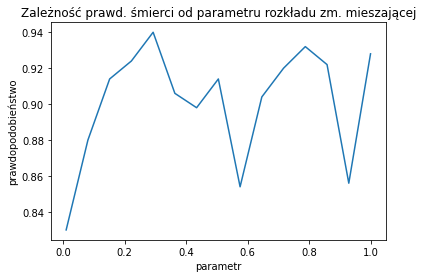

In [45]:
times9 = [i[0] for i in data9]
prob = [i[1] for i in data9]
plt.plot(np.linspace(0.01, 1, 15, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru rozkładu zm. mieszającej")
plt.xlabel("parametr")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów


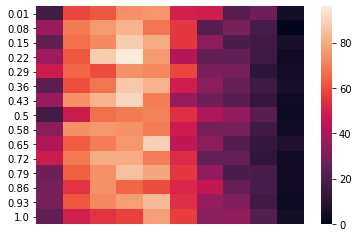

In [46]:
print("Heatmapa momentów śmierci dla różnych parametrów")
make_heatmap(times9, np.round(np.linspace(0.01, 1, 15, endpoint=True),2))

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej aut jadących z prawej strony dla 1000 prób Monte Carlo. Zmienna mieszająca dla aut jadących z lewej strony pochodzi z rozkładu $U(0, 0.1)$.

In [47]:
data10 = [probability2(1000, fun1=np.random.uniform(0,  0.1), fun2=np.random.uniform(0, i)) for i in np.linspace(0.01, 1, 15, endpoint=True)]

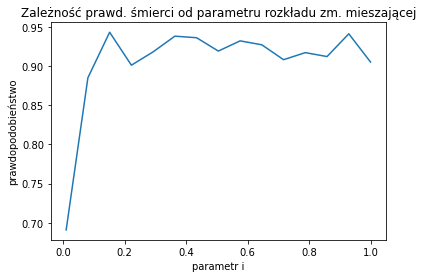

In [48]:
times10 = [i[0] for i in data10]
prob = [i[1] for i in data10]
plt.plot(np.linspace(0.01, 1, 15, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru rozkładu zm. mieszającej")
plt.xlabel("parametr i")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów


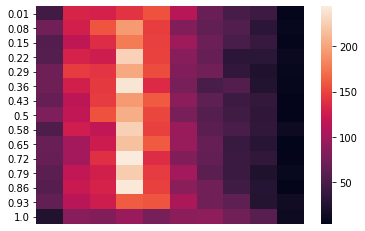

In [49]:
print("Heatmapa momentów śmierci dla różnych parametrów")
make_heatmap(times10, np.round(np.linspace(0.01, 1, 15, endpoint=True),2))

**Wnioski**

W obu przypadkach prawdopodobieństwo śmierci pijaka jest bardzo wysokie (ok. 90%).

Auta jadące z prawej strony pojawiają się zgodnie z mieszanym procesem Poissona ze zmienną mieszającą z rozkładu jednostajnego, natomiast auta jadące z lewej strony ze zmienną mieszającą z rozkładu $Exp(0.03)$.

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej aut jadących z prawej strony dla 1000 prób Monte Carlo.

In [50]:
data11 = [probability2(1000, fun2=np.random.uniform(0, i)) for i in np.linspace(0.01, 1, 15, endpoint=True)]

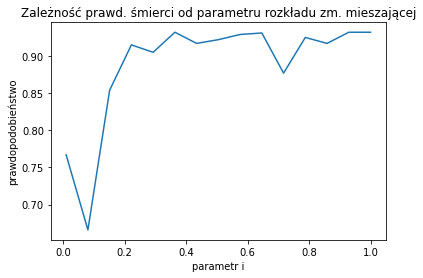

In [51]:
times11 = [i[0] for i in data11]
prob = [i[1] for i in data11]
plt.plot(np.linspace(0.01, 1, 15, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru rozkładu zm. mieszającej")
plt.xlabel("parametr i")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów


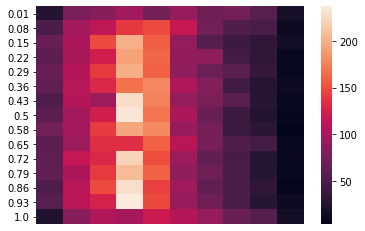

In [52]:
print("Heatmapa momentów śmierci dla różnych parametrów")
make_heatmap(times11, np.round(np.linspace(0.01, 1, 15, endpoint=True),2))

Auta jadące z lewej strony pojawiają się zgodnie z mieszanym procesem Poissona ze zmienną mieszającą z rozkładu jednostajnego, natomiast auta jadące z prawej strony ze zmienną mieszającą z rozkładu $Exp(0.03)$.

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej aut jadących z lewej strony dla 500 prób Monte Carlo.

In [53]:
data12 = [probability2(500, fun1=np.random.uniform(0, i)) for i in np.linspace(0.01, 1, 15, endpoint=True)]

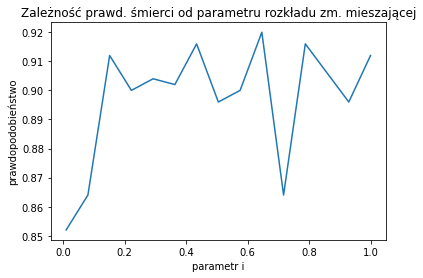

In [54]:
times12 = [i[0] for i in data12]
prob = [i[1] for i in data12]
plt.plot(np.linspace(0.01, 1, 15, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru rozkładu zm. mieszającej")
plt.xlabel("parametr i")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów


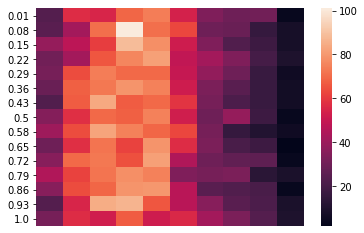

In [55]:
print("Heatmapa momentów śmierci dla różnych parametrów")
make_heatmap(times12, np.round(np.linspace(0.01, 1, 15, endpoint=True),2))

Auta pojawiają się zgodnie z mieszanym procesem Poissona ze zmienną mieszającą z rozkładu Gamma.

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej aut jadących z lewej strony dla 500 prób Monte Carlo. Zmienna mieszająca dla aut jadących z prawej strony pochodzi z rozkładu $G(0.03)$.

In [56]:
data7 = [probability2(500, fun1=np.random.gamma(i), fun2=np.random.gamma(0.03)) for i in np.linspace(0.01, 0.9, 12, endpoint=True)]

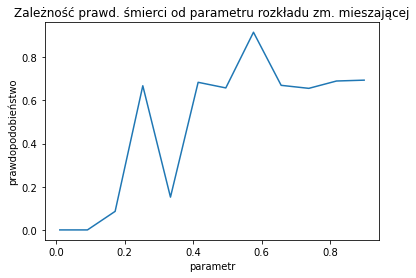

In [57]:
times7 = [i[0] for i in data7]
prob = [i[1] for i in data7]
plt.plot(np.linspace(0.01, 0.9, 12, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru rozkładu zm. mieszającej")
plt.xlabel("parametr")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów


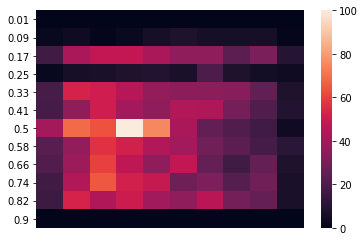

In [58]:
print("Heatmapa momentów śmierci dla różnych parametrów")
make_heatmap(times7, np.round(np.linspace(0.01, 0.9, 12, endpoint=True),2))

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej 
aut jadących z prawej strony dla 500 prób Monte Carlo. Zmienna mieszająca dla aut jadących z lewej strony pochodzi z rozkładu $G(0.03)$.

In [59]:
data8 = [probability2(500, fun1=np.random.gamma(0.3), fun2=np.random.gamma(i)) for i in np.linspace(0.01, 0.9, 15, endpoint=True)]

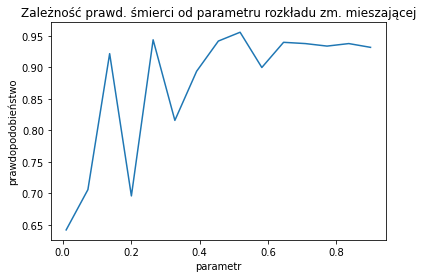

In [60]:
times8 = [i[0] for i in data8]
prob = [i[1] for i in data8]
plt.plot(np.linspace(0.01, 0.9, 15, endpoint=True), prob)
plt.title("Zależność prawd. śmierci od parametru rozkładu zm. mieszającej")
plt.xlabel("parametr")
plt.ylabel("prawdopodobieństwo")
plt.show()

Heatmapa momentów śmierci dla różnych parametrów


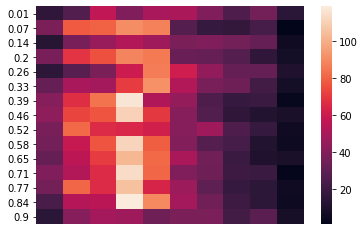

In [61]:
print("Heatmapa momentów śmierci dla różnych parametrów")
make_heatmap(times8, np.round(np.linspace(0.01, 0.9, 15, endpoint=True),2))

**Wnioski**

Jest to tylko garstka przykładowych analiz. Prawdopodobieństwo śmierci pijaka można badać w zależności od wielu zmiennych.

#Analiza prawdopodobieństwa uogólnionego ruchu pijaka



Wszystkie poniższe analizy zostały wykonane dla 100 prób Monte Carlo.

In [ ]:
def gen_prob(n, d=10, vel=1, Nt=np.random.exponential(0.03), Mt=np.random.exponential(0.03), v_m=8.333 ,v_M=13.8888,
             Z_dist = "Normal", a=1, V_dist="Normal", A=0, B=1, l_appear='mmp', r_appear='mmp'): 
    """Arguments:
    n - number of simulations,
    d - width of the road
    vel - drunk velocity
    Nt, Mt - random variable for the poisson process
    v_m - minimum of the cars velocities
    v_M - maximum of the cars velocities
    Z_dist - first distribution for theta process
    a - parameter for Z distribution
    V_dist - second distribution for theta process
    A, B - parameters for V_distribution
    l_appear - type of process for cars appearing on the left
    r_appear - type of process for cars appearing on the right
    Return: 
    times - list of moments of death
    dead/n - probability of death in n trials
    """
    dead = 0
    times = []
    for i in range(n):
        street = Street(d, v_m, v_M)
        street.put_drunk(Drunk(vel=vel, theta=True, Z_dist=Z_dist, a=1, V_dist=V_dist, A=A, B=B ))
        street.generate_cars_left(Nt, l_appear=l_appear)
        street.generate_cars_right(Mt, r_appear=r_appear)
        while street.t < street.T:
            a = street.step()
            if a:
                dead += 1
                times.append(a)
    return times, dead/n

Prawdopodobieństwo w zależności od szerokości ulicy d



In [ ]:
def d_prob(a=[1, 2, 3] , A=[0, 0.5, 1], B=[0.5, 1, 1.5], Z_dist='Normal', V_dist='Normal', A_con=0, B_con=1, n=100):
    """Arguments:
    a - list of parameter for Z distribution
    A, B - lista of A parametrs parameters for V_distribution
    Z_dist - first distribution for theta process
    V_dist - second distribution for theta process
    A_con - A constant
    B_con - B constant
    n - number of simulations,
    """
    for j in a:
        d1_1 = [gen_prob(n, d=i, a=j, A=A_con, B=B_con, Z_dist=Z_dist, V_dist=V_dist) for i in np.linspace(5, 15, 10)]
        prob1 = [i[1] for i in d1_1]
        plt.plot(np.linspace(5, 15, 10), prob1)
    plt.legend(['a='+str(i) for i in a])

    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od d i a, A={}".format(str(A_con)))
    else:
        plt.title("Zależność prawd. śmierci od d i a, A={}, B={}".format(str(A_con), str(B_con)))
    plt.xlabel("d")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    for j in A:
        d1_1 = [gen_prob(n, d=i, A=j, Z_dist=Z_dist, V_dist=V_dist, B=2) for i in np.linspace(5, 15, 10)]
        prob1 = [i[1] for i in d1_1]
        plt.plot(np.linspace(5, 15, 10), prob1)
    
    plt.legend(['A='+str(i) for i in A])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od d i A, a=1")
    else:
        plt.title("Zależność prawd. śmierci od d i A, B=2, a=1")
    plt.xlabel("d")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    if V_dist != 'Expon':
        for j in B:
            d1_1 = [gen_prob(n, d=i, B=j, Z_dist=Z_dist, V_dist=V_dist) for i in np.linspace(5, 15, 10)]
            prob1 = [i[1] for i in d1_1]
            plt.plot(np.linspace(5, 15, 10), prob1)
    
        plt.legend(['B='+str(i) for i in B])
        plt.title("Zależność prawd. śmierci od d i B, A=0, a=1")
        plt.xlabel("d")
        plt.ylabel("prawdopodobieństwo")
        plt.show()

Zależność prawdopodopodobieństwa śmierci pijaka od szerekości ulicy d oraz parametrów rozkładów a, A oraz B. $Z_i \sim N(0, a)$, $V_i \sim N(A, B)$  .

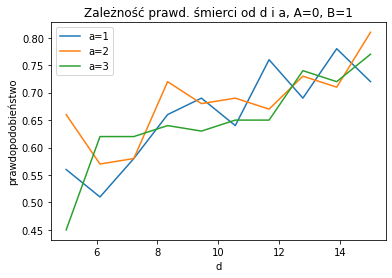

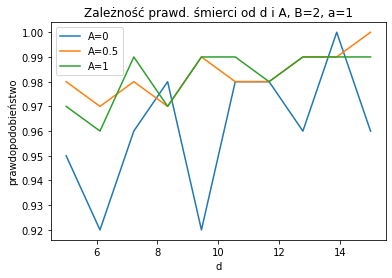

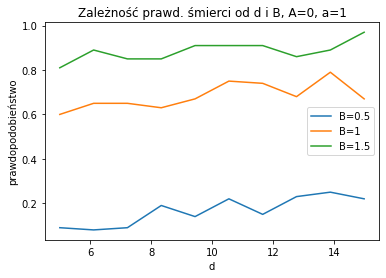

In [ ]:
d_prob()

**Wnioski**

Prawdopodobieństwo śmierci pijaka rośnie w każdym z badanych przypadków i parametrów. 

Zależność prawdopodopodobieństwa śmierci pijaka od szerekości ulicy d oraz parametrów rozkładów a, A oraz B. $Z_i \sim Exp(a)$, $V_i \sim LogN(A, B)$  .

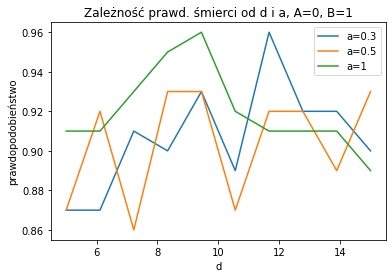

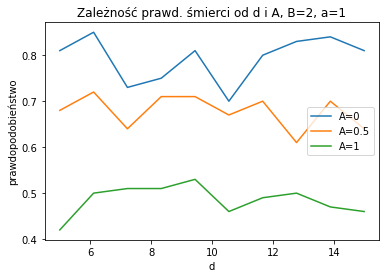

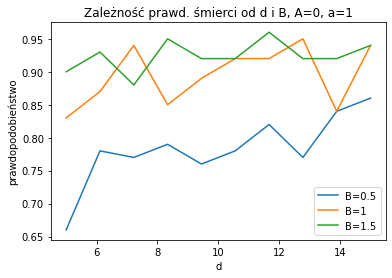

In [ ]:
d_prob(a=[0.3, 0.5, 1], Z_dist='Expon', V_dist='LogNorm')

**Wnioski**

Prawdopodobieństwo śmierci pijaka rośnie wraz ze wzrostem parametrów a, A oraz B. W powyższych przypadkach dla dużych wartości B (powyżej 1) prawdopodobieństwo śmierci pijaka jest bardzo wysokie (ok. 90%).

Zależność prawdopodopodobieństwa śmierci pijaka od szerekości ulicy d oraz parametrów rozkładów a oraz B. $Z_i \sim Exp(a)$, $V_i \sim Exp(A)$  .

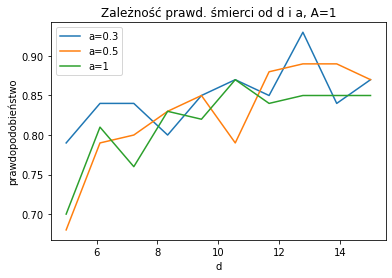

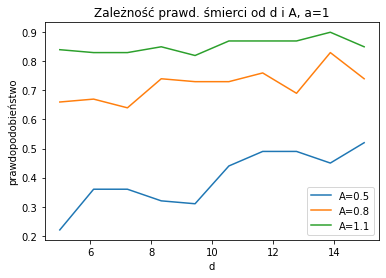

In [ ]:
d_prob(a=[0.3, 0.5, 1], A=[0.5, 0.8, 1.1], Z_dist='Expon', V_dist='Expon', A_con=1)

**Wnioski**

Prawdopodobieństwo śmierci pijaka rośnie wraz ze wzrostem parametrów a i A.


Prawdopodobieństwo w zależności od prędkości pijaka




In [ ]:
def v_prob(a=[1, 2, 3] , A=[0, 0.5, 1], B=[0.5, 1, 1.5], Z_dist='Normal', V_dist='Normal', A_con=0, B_con=1.5, n=100):
    """Arguments:
    a - list of parameter for Z distribution
    A, B - lista of A parametrs parameters for V_distribution
    Z_dist - first distribution for theta process
    V_dist - second distribution for theta process
    A_con - A constant
    B_con - B constant
    n - number of simulations,
    """
    for j in a:
        d1_1 = [gen_prob(n, vel=i, a=j, Z_dist=Z_dist, V_dist=V_dist, A=A_con, B=B_con) for i in np.linspace(0.5, 2, 10)]
        prob1 = [i[1] for i in d1_1]
        plt.plot(np.linspace(0.5, 2, 10), prob1)
    plt.legend(['a='+str(i) for i in a])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od v pijaka i a, A={}".format(str(A_con)))
    else:
        plt.title("Zależność prawd. śmierci od v pijaka i a, A={}, B={}".format(str(A_con), str(B_con)))
    plt.xlabel("prędkość pijaka")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    for j in A:
        d1_1 = [gen_prob(n, vel=i, A=j, Z_dist=Z_dist, V_dist=V_dist, B=2) for i in np.linspace(0.5, 2, 10)]
        prob1 = [i[1] for i in d1_1]
        plt.plot(np.linspace(0.5, 2, 10), prob1)
    
    plt.legend(['A='+str(i) for i in A])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od v pijaka i A, a=1")
    else:
        plt.title("Zależność prawd. śmierci od v pijaka i A, B=2, a=1")
    plt.xlabel("prędkość pijaka")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    if V_dist != 'Expon':
        for j in B:
            d1_1 = [gen_prob(n, vel=i, B=j, Z_dist=Z_dist, V_dist=V_dist) for i in np.linspace(0.5, 2, 10)]
            prob1 = [i[1] for i in d1_1]
            plt.plot(np.linspace(0.5, 2, 10), prob1)
        
        plt.legend(['B='+str(i) for i in B])
        plt.title("Zależność prawd. śmierci od v pijaka i B, A=0, a=1")
        plt.xlabel("prędkość pijaka")
        plt.ylabel("prawdopodobieństwo")
        plt.show()


Zależność prawdopodopodobieństwa śmierci pijaka od jego prędkości oraz parametrów rozkładów a, A oraz B. $Z_i \sim N(0,a)$, $V_i \sim N(A, B)$  .

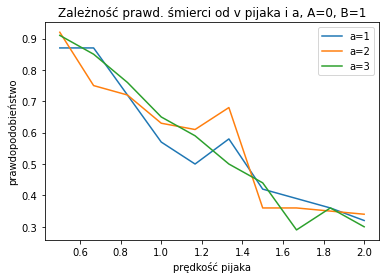

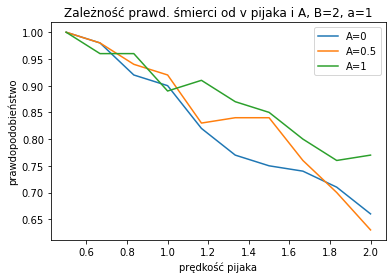

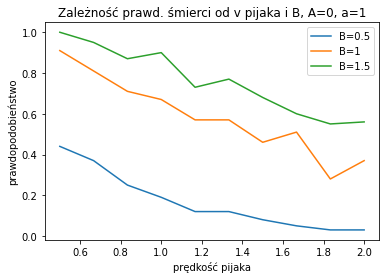

In [ ]:
v_prob()

Zależność prawdopodopodobieństwa śmierci pijaka od jego prędkości oraz parametrów rozkładów a, A oraz B. $Z_i \sim Exp(a)$, $V_i \sim U(A, B)$.

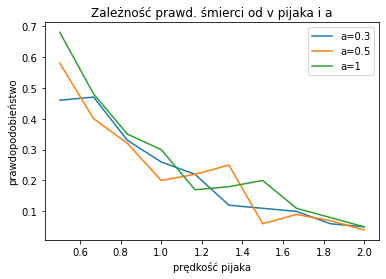

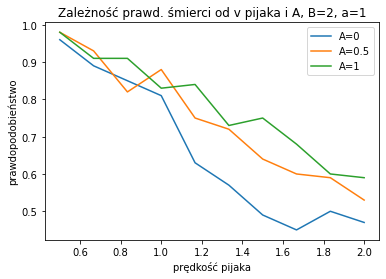

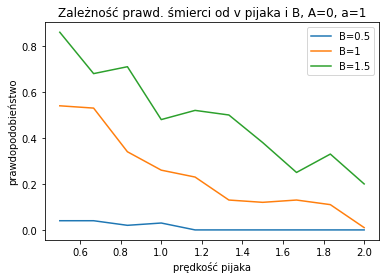

In [ ]:
v_prob(a=[0.3, 0.5, 1], Z_dist='Expon', V_dist='Uniform')

Zależność prawdopodopodobieństwa śmierci pijaka od jego prędkości oraz parametrów rozkładów a oraz A. $Z_i \sim Exp(a)$, $V_i \sim Exp(A)$  .

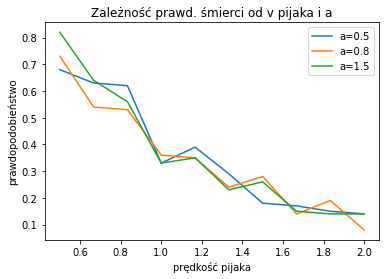

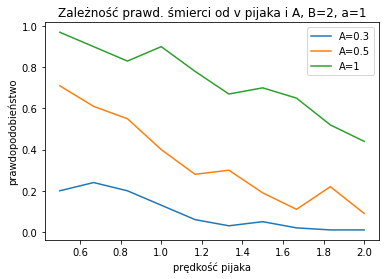

In [ ]:
v_prob(a=[0.5, 0.8, 1.5], A=[0.3, 0.5, 1], Z_dist='Expon', V_dist='Expon', A_con=0.5)

Zależność prawdopodopodobieństwa śmierci pijaka od jego prędkości oraz parametrów rozkładów a oraz A. $Z_i \sim U(0,a)$, $V_i \sim Exp(A)$  .

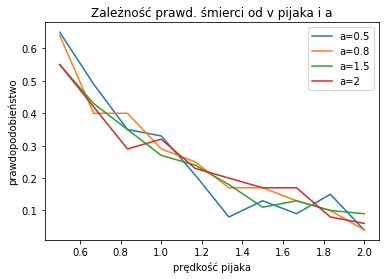

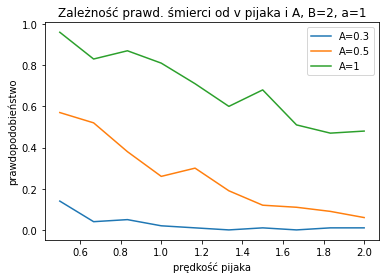

In [ ]:
v_prob(a=[0.5, 0.8, 1.5, 2], A=[0.3, 0.5, 1], Z_dist='Uniform', V_dist='Expon', A_con=0.5)

**Wnioski**

Prawdopodobieństwo śmierci pijaka w zależności od jego prędkości maleje w każdym z badanych przypadków.

Prawdopodobieństwo w zależności od prędkości samochodów



In [ ]:
def car_vm_prob(v_m = 8.333, v_M = 13.8888, a=[1, 2, 3], A=[0.1, 0.5, 1], B=[0.5, 1, 1.5], Z_dist='Normal', V_dist='Normal', A_con=0, B_con=1, n=100):
    """Arguments:
    v_m - minimum of the cars velocities
    v_M - maximum of the cars velocities
    a - list of parameter for Z distribution
    A, B - lista of A parametrs parameters for V_distribution
    Z_dist - first distribution for theta process
    V_dist - second distribution for theta process
    A_con - A constant
    B_con - B constant
    n - number of simulations,
    """
    for j in a:
        d1_1 = [gen_prob(n, v_m=i, v_M=v_M, a=j, Z_dist=Z_dist, V_dist=V_dist, A=A_con, B=B_con) for i in np.linspace(0, 12, 13, endpoint=True)]
        prob1 = [i[1] for i in d1_1]
        plt.plot(np.linspace(0, 12, 13, endpoint=True), prob1)
    plt.legend(['a='+str(i) for i in a])

    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od v_m i a, A={}, v_M=13.9".format(str(A_con)))
    else:
        plt.title("Zależność prawd. śmierci od v_m i a, A={}, B={} v_M=13.9".format(str(A_con), str(B_con)))
    plt.xlabel("v_m")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    for j in A:
        d1_1 = [gen_prob(n, v_m=i, v_M=v_M, A=j, Z_dist=Z_dist, V_dist=V_dist, B=2) for i in np.linspace(0, 12, 13, endpoint=True)]
        prob1 = [i[1] for i in d1_1]
        plt.plot(np.linspace(0, 12, 13, endpoint=True), prob1)
    
    plt.legend(['A='+str(i) for i in A])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od v_m i A, v_M=13.9")
    else:
        plt.title("Zależność prawd. śmierci od v_m i A, B=2, v_M=13.9")
    plt.xlabel("v_m")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    if V_dist != 'Expon':
        for j in B:
            d1_1 = [gen_prob(n, v_m=i, v_M=v_M, B=j, Z_dist=Z_dist, V_dist=V_dist) for i in np.linspace(0, 12, 13, endpoint=True)]
            prob1 = [i[1] for i in d1_1]
            plt.plot(np.linspace(0, 12, 13, endpoint=True), prob1)
        
        plt.legend(['B='+str(i) for i in B])
        plt.title("Zależność prawd. śmierci od v_m i B, A=0, v_M=13.9")
        plt.xlabel("v_m")
        plt.ylabel("prawdopodobieństwo")
        plt.show()

Zależność prawdopodopodobieństwa śmierci pijaka od prędkości samochodów oraz parametrów rozkładów a, A oraz B. $Z_i \sim N(0,a)$, $V_i \sim N(A, B)$.

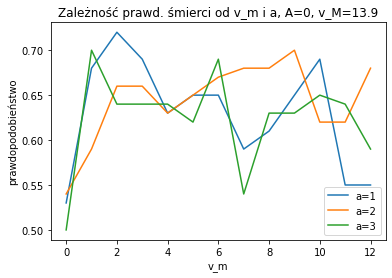

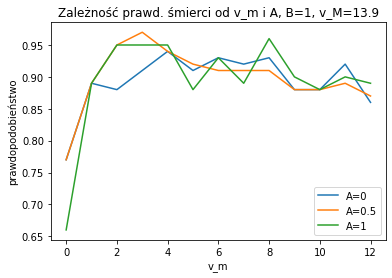

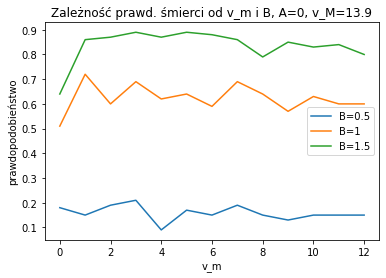

In [ ]:
car_vm_prob()

**Wnioski**

Prawdopodobieństwo śmierci pijaka jest duże dla wiekszych parametrów a, A i B.

In [ ]:
def car_vM_prob(v_m = 0.5, a=[1, 2, 3], A=[0.2, 0.5, 1], B=[0.5, 1, 1.5], Z_dist='Normal', V_dist='Normal', A_con=0, B_con=1, n=100):
    """Arguments:
    v_m - minimum of the cars velocities
    a - list of parameter for Z distribution
    A, B - lista of A parametrs parameters for V_distribution
    Z_dist - first distribution for theta process
    V_dist - second distribution for theta process
    A_con - A constant
    B_con - B constant
    n - number of simulations,
    """
    for j in a:
        d1_1 = [gen_prob(n, v_M=i, v_m=v_m, a=j, Z_dist=Z_dist, V_dist=V_dist, A=A_con, B=B_con) for i in np.linspace(1, 13.8888, 13, endpoint=True)]
        prob1 = [i[1] for i in d1_1]
        plt.plot(np.linspace(1, 13.8888, 13, endpoint=True), prob1)
    plt.legend(['a='+str(i) for i in a])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od v_M i a, A={}, v_m=0.5".format(str(A_con)))
    else:
        plt.title("Zależność prawd. śmierci od v_M i a, A={}, B={}, v_m=0.5".format(str(A_con), str(B_con)))
    plt.xlabel("v_M")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    for j in A:
        d1_1 = [gen_prob(n, v_M=i, v_m=v_m, A=j, Z_dist=Z_dist, V_dist=V_dist, B=2) for i in np.linspace(1, 13.8888, 13, endpoint=True)]
        prob1 = [i[1] for i in d1_1]
        plt.plot(np.linspace(1, 13.8888, 13, endpoint=True), prob1)
    
    plt.legend(['A='+str(i) for i in A])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od v_M i A, v_m=0.5")
    else:
        plt.title("Zależność prawd. śmierci od v_M i A, B=2, v_m=0.5")
    plt.xlabel("v_M")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    if V_dist != 'Expon':
        for j in B:
            d1_1 = [gen_prob(n, v_M=i, v_m=v_m, B=j, Z_dist=Z_dist, V_dist=V_dist) for i in np.linspace(1, 13.8888, 13, endpoint=True)]
            prob1 = [i[1] for i in d1_1]
            plt.plot(np.linspace(1, 13.8888, 13, endpoint=True), prob1)
        
        plt.legend(['B='+str(i) for i in B])
        plt.title("Zależność prawd. śmierci od v_M i B, A=0, v_m=0.5")
        plt.xlabel("v_M")
        plt.ylabel("prawdopodobieństwo")
        plt.show()

Zależność prawdopodopodobieństwa śmierci pijaka od prędkości samochodów oraz parametrów rozkładów a, A oraz B. $Z_i \sim N(0,a)$, $V_i \sim N(A, B)$.

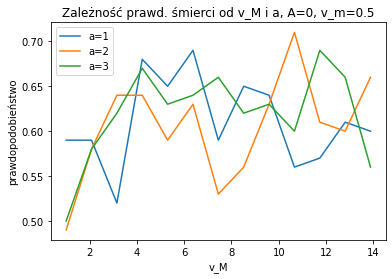

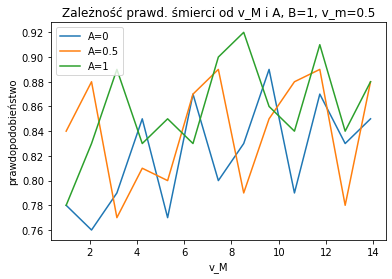

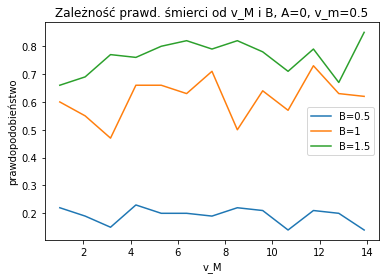

In [ ]:
car_vM_prob()

**Wnioski**

Prawdopodobieństwo śmierci pijaka oscyluje w zależności od parametrów a (ok. 60%) i A (ok. 80%).

Zależność prawdopodopodobieństwa śmierci pijaka od prędkości samochodów oraz parametrów rozkładów a i A. $Z_i \sim U(0,a)$, $V_i \sim Exp(A)$.

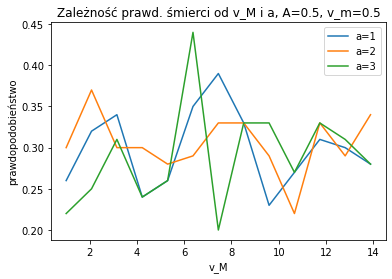

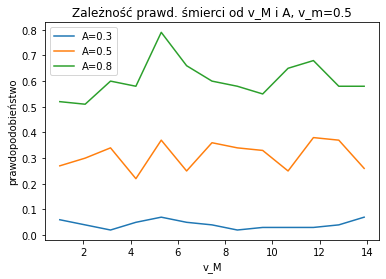

In [ ]:
car_vM_prob(A=[0.3, 0.5, 0.8], Z_dist='Uniform', V_dist='Expon', A_con=0.5)

W tym przypadku prawdopodobieństwo śmierci pijaka od a i prędkości maksymalnej jest dość niskie (ok. 30%) w porównaniu z poprzednimi przypadkami.

Prawdopodobieństwo w zależności od rozkładów Nt i Mt





In [ ]:
def gen_prob2(n, d=10, vel=1, fun_1=np.random.exponential(0.03), fun_2=np.random.exponential(0.03), v_m=8.333 ,v_M=13.8888,
              Z_dist="Normal", a=1, V_dist="Normal", A=0, B=1, l_appear='mmp', r_appear='mmp'): 
    """Arguments:
    n - number of simulations,
    d - width of the road
    vel - drunk velocity
    fun_1, fun_2 - random variable for the poisson process
    v_m - minimum of the cars velocities
    v_M - maximum of the cars velocities
    Z_dist - first distribution for theta process
    a - parameter for Z distribution
    V_dist - second distribution for theta process
    A, B - parameters for V_distribution
    l_appear - type of process for cars appearing on the left
    r_appear - type of process for cars appearing on the right
    Return: 
    times - list of moments of death
    dead/n - probability of death in n trials
    """
    
    dead = 0
    times = []
    for i in range(n):
        Nt = fun_1
        Mt = fun_2
        street = Street(d, v_m, v_M)
        street.put_drunk(Drunk(vel=vel, theta=True, Z_dist=Z_dist, a=1, V_dist=V_dist, A=A, B=B ))
        street.generate_cars_left(Nt, l_appear=l_appear)
        street.generate_cars_right(Mt, r_appear=r_appear)
        while street.t < street.T:
            a = street.step()
            if a:
                dead += 1
                times.append(a)
    return times, dead/n

In [ ]:
def dist_prob_l(a=[1, 2, 3], A=[0.2, 0.5, 1], B=[0.5, 1, 1.5], Z_dist='Normal', V_dist='Normal',
              fun_1=np.random.exponential(0.03), fun_2=np.random.exponential(0.03), n=100,
              l1=np.linspace(0.01, 0.8, 10, endpoint=True),
              A_con=0, B_con=1, l_appear='mmp', r_appear='mmp'):
  
    """Arguments:
    a - list of parameter for Z distribution
    A, B - lista of A parametrs parameters for V_distribution
    n - number of simulations,
    Z_dist - first distribution for theta process
    V_dist - second distribution for theta process
    fun_1, fun_2 - random variable for the poisson process
    n - number of simulations
    l1 - parameter list for the selected process for cars appearing on the left
    A_con - A constant
    B_con - B constant
    l_appear - type of process for cars appearing on the left
    r_appear - type of process for cars appearing on the right
    """
    for j in a:
        d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, fun_1=i, fun_2=fun_2, a=j,\
                          Z_dist=Z_dist, V_dist=V_dist, A=A_con, B=B_con) for i in l1]
        prob1 = [i[1] for i in d1_1]
        plt.plot(l1, prob1)
    plt.legend(['a='+str(i) for i in a])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od parametru int. l i a")

    else:
        plt.title("Zależność prawd. śmierci od parametru int. l i a, A={}, B={}".format(str(A_con), str(B_con)))
    plt.xlabel("parametr rozkładu")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    for j in A:
        d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, A=j, fun_1=i, fun_2=fun_2,\
                          Z_dist=Z_dist, V_dist=V_dist, B=2) for i in l1]
        prob1 = [i[1] for i in d1_1]
        plt.plot(l1, prob1)
    
    plt.legend(['A='+str(i) for i in A])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od parametru int. l i A")
    else:
        plt.title("Zależność prawd. śmierci od parametru int. l i A, B=2")
    plt.xlabel("parametr rozkładu")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    if V_dist != 'Expon':
        for j in B:
            d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, B=j, fun_1=i, fun_2=fun_2,\
                              Z_dist=Z_dist, V_dist=V_dist) for i in l1]
            prob1 = [i[1] for i in d1_1]
            plt.plot(l1, prob1)
        
        plt.legend(['B='+str(i) for i in B])
        plt.title("Zależność prawd. śmierci od parametru int. l i B, A=0")
        plt.xlabel("parametr rozkładu")
        plt.ylabel("prawdopodobieństwo")
        plt.show()

Auta pojawiają się zgodnie z jednorodnym procesem Poissona.

Zależność prawdopodopodobieństwa śmierci pijaka od parametru intensywności aut pojawiających się z lewej strony oraz parametrów rozkładów a, A oraz B. $Z_i \sim N(0,a)$, $V_i \sim N(A,B)$. Parametr intensywności dla aut pojawiających się z prawej strony wynosi 0,05.

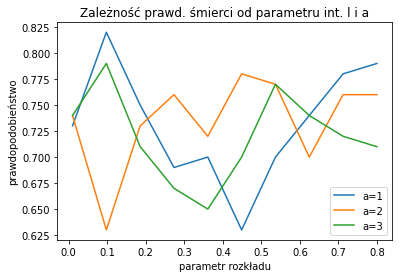

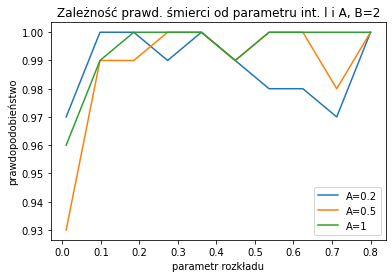

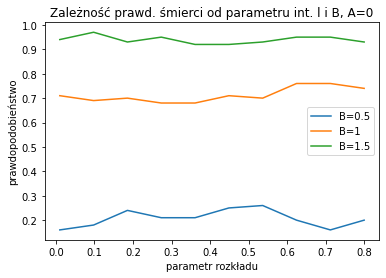

In [ ]:
dist_prob_l(l_appear='jpp', r_appear='jpp', fun_2=0.05 )

**Wnioski**


Prawdopodobieństwo śmierci pijaka jest bardzo wysokie, gdy auta pojawiają się zgodnie z jednorodnym procesem Poissona.

Zależność prawdopodopodobieństwa śmierci pijaka od parametru intensywności aut pojawiających się z lewej strony oraz parametrów rozkładów a i A. $Z_i \sim Exp(a)$, $V_i \sim Exp(A)$. Parametr intensywności dla aut pojawiających się z prawej strony wynosi 0,05.

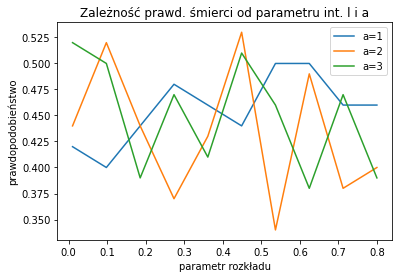

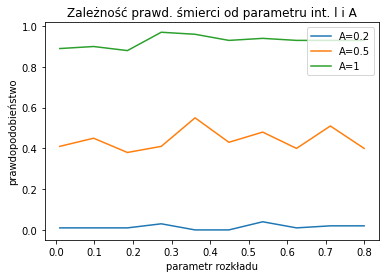

In [ ]:
dist_prob_l(l_appear='jpp', r_appear='jpp', fun_2=0.05, Z_dist='Expon', V_dist='Expon', A_con=0.5)

**Wnioski**

Dla badanych a prawdopodobieństwo śmierci pijaka oscyluje wokół 45%.
Dla badanych A prawdopodobieństwo śmierci pijaka niewiele się zmienia dla konkretnego parametru. Pijak ma niewielkie szanse na przeżycie, gdy A=1.

In [ ]:
def dist_prob_r(a=[1, 2, 3], A=[0.2, 0.5, 1], B=[0.5, 1, 1.5], Z_dist='Normal', V_dist='Normal',
              fun_1=np.random.exponential(0.03), fun_2=np.random.exponential(0.03), n=100, 
              l2=np.linspace(0.01, 0.8, 10, endpoint=True), A_con=0, B_con=1, l_appear='mmp', r_appear='mmp'):
    """Arguments:
    a - list of parameter for Z distribution
    A, B - lista of A parametrs parameters for V_distribution
    n - number of simulations,
    Z_dist - first distribution for theta process
    V_dist - second distribution for theta process
    fun_1, fun_2 - random variable for the poisson process
    n - number of simulations
    l2 - parameter list for the selected process for cars appearing on the right
    A_con - A constant
    B_con - B constant
    l_appear - type of process for cars appearing on the left
    r_appear - type of process for cars appearing on the right
    """
    for j in a:
        d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, fun_1=fun_1, fun_2=i, a=j,Z_dist=Z_dist, V_dist=V_dist, A=A_con, B=B_con) for i in l2]
        prob1 = [i[1] for i in d1_1]
        plt.plot(l2, prob1)
    plt.legend(['a='+str(i) for i in a])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od parametru int. l i a")

    else:
        plt.title("Zależność prawd. śmierci od parametru int. l i a, A={}, B={}".format(str(A_con), str(B_con)))
    plt.xlabel("parametr rozkładu")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    for j in A:
        d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, A=j, fun_1=fun_1, fun_2=i, Z_dist=Z_dist, V_dist=V_dist, B=2) for i in l2]
        prob1 = [i[1] for i in d1_1]
        plt.plot(l2, prob1)
    
    plt.legend(['A='+str(i) for i in A])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od parametru int. l i A")
    else:
        plt.title("Zależność prawd. śmierci od parametru int. l i A, B=2")
    plt.xlabel("parametr rozkładu")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    if V_dist != 'Expon':
        for j in B:
            d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, B=j, fun_1=fun_1, fun_2=i, Z_dist=Z_dist, V_dist=V_dist) for i in l2]
            prob1 = [i[1] for i in d1_1]
            plt.plot(l2, prob1)
        
        plt.legend(['B='+str(i) for i in B])
        plt.title("Zależność prawd. śmierci od parametru int. l i B, A=0")
        plt.xlabel("parametr rozkładu")
        plt.ylabel("prawdopodobieństwo")
        plt.show()

Zależność prawdopodopodobieństwa śmierci pijaka od parametru intensywności aut pojawiających się z prawej strony oraz parametrów rozkładów a, A oraz B.  $Z_i∼N(0,a)$ ,  $V_i∼N(A,B)$ . Parametr intensywności dla aut pojawiających się z lewej strony wynosi 0,05.

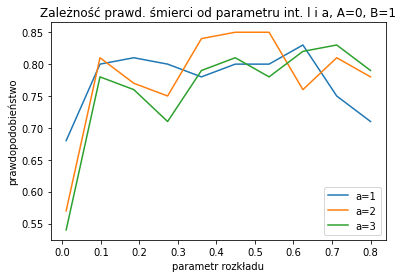

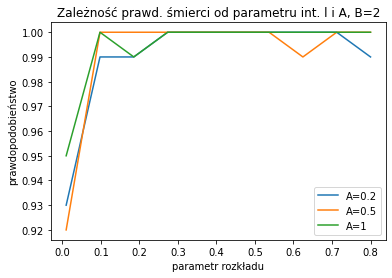

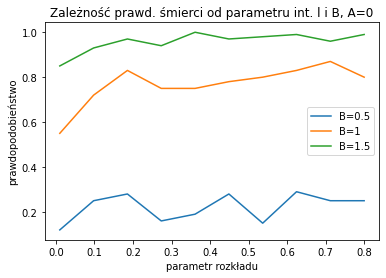

In [ ]:
dist_prob_r(l_appear='jpp', r_appear='jpp', fun_1=0.05 )

**Wnioski**

Prawdopodobieństwo śmierci pijaka jest bardzo wysokie.

Zależność prawdopodopodobieństwa śmierci pijaka od parametru intensywności aut pojawiających się z prawej strony oraz parametrów rozkładów a i A.  $Z_i∼Exp(a)$ ,  $V_i∼Exp(A)$ . Parametr intensywności dla aut pojawiających się z lewej strony wynosi 0,05.

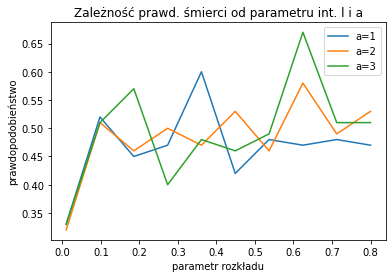

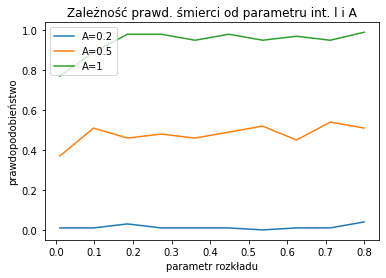

In [ ]:
dist_prob_r(l_appear='jpp', r_appear='jpp', fun_1=0.05, Z_dist='Expon', V_dist='Expon', A_con=0.5)

Auta jadące z lewej strony pojawiają się zgodnie z jednorodnym procesem Poissona, natomiast auta jadące z prawej strony pojawiają się zgodnie z niejednorodnym procesem Poissona z funkcją intensywności $f(t) = \exp(-t^2)$.

Zależność prawdopodopodobieństwa śmierci pijaka od parametru intensywności aut pojawiających się z lewej strony oraz parametrów rozkładów a i A.  $Z_i∼Exp(a)$ ,  $V_i∼Exp(A)$ .

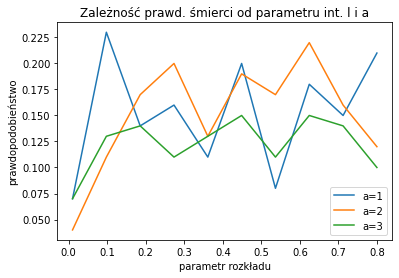

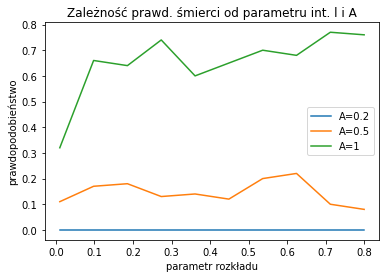

In [ ]:
dist_prob_l(l_appear='jpp', r_appear='npp', fun_2=l[1], Z_dist='Expon', V_dist='Expon', A_con=0.5)

**Wnioski**

Dla badanych wartości a pijak ma duże szanse na przeżycie.

Auta jadące z lewej strony pojawiają się zgodnie z mieszanym procesem Poissona ze zmienną mieszającą z rozkładu $Exp(0.03)$, natomiast auta jadące z prawej strony pojawiają się zgodnie z jednorodnym procesem Poissona.

Zależność prawdopodopodobieństwa śmierci pijaka od parametru intensywności aut pojawiających się z prawej strony oraz parametrów rozkładów a, A oraz B.  $Z_i∼N(0,a)$ ,  $V_i∼LogN(A, B)$ .

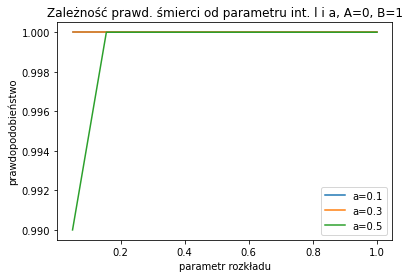

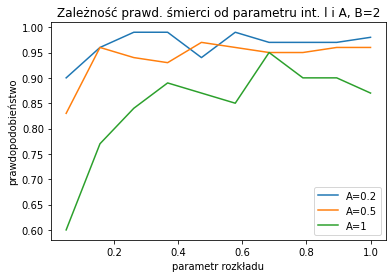

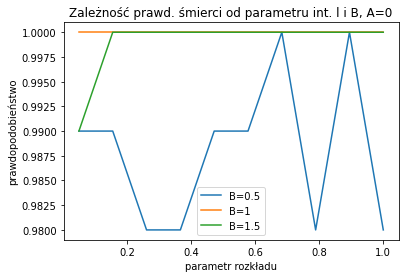

In [ ]:
dist_prob_l(a=[0.1, 0.3, 0.5], l_appear='jpp', Z_dist='Normal', V_dist='LogNorm', l1=np.linspace(0.05, 1, 10, endpoint=True))

**Wnioski**

W powyższym przypadku pijak ma nikłe szanse na przeżycie.

Zależność prawdopodobieństwa śmierci od zmiennej mieszającej mieszanego procesu Poissona.

In [ ]:
def prob_l(a=[1, 2, 3], A=[0.2, 0.5, 1], B=[0.5, 1, 1.5], Z_dist='Normal', V_dist='Normal',
              fun_1=np.random.exponential, fun_2=np.random.exponential(0.03), n=100,
              l1=np.linspace(0.01, 0.8, 10, endpoint=True),
              A_con=0, B_con=1, l_appear='mmp', r_appear='mmp'):
  
    """Arguments:
    a - list of parameter for Z distribution
    A, B - lista of A parametrs parameters for V_distribution
    n - number of simulations,
    Z_dist - first distribution for theta process
    V_dist - second distribution for theta process
    fun_1, fun_2 - random variable for the poisson process
    n - number of simulations
    l1 - parameter list for the selected process for cars appearing on the left
    A_con - A constant
    B_con - B constant
    l_appear - type of process for cars appearing on the left
    r_appear - type of process for cars appearing on the right
    """
    for j in a:
        d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, fun_1=fun_1(i), fun_2=fun_2, a=j,\
                          Z_dist=Z_dist, V_dist=V_dist, A=A_con, B=B_con) for i in l1]
        prob1 = [i[1] for i in d1_1]
        plt.plot(l1, prob1)
    plt.legend(['a='+str(i) for i in a])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od parametru int. l i a")

    else:
        plt.title("Zależność prawd. śmierci od parametru int. l i a, A={}, B={}".format(str(A_con), str(B_con)))
    plt.xlabel("parametr rozkładu")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    for j in A:
        d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, A=j, fun_1=fun_1(i), fun_2=fun_2,\
                          Z_dist=Z_dist, V_dist=V_dist, B=2) for i in l1]
        prob1 = [i[1] for i in d1_1]
        plt.plot(l1, prob1)
    
    plt.legend(['A='+str(i) for i in A])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od parametru int. l i A")
    else:
        plt.title("Zależność prawd. śmierci od parametru int. l i A, B=2")
    plt.xlabel("parametr rozkładu")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    if V_dist != 'Expon':
        for j in B:
            d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, B=j, fun_1=fun_1(i), fun_2=fun_2,\
                              Z_dist=Z_dist, V_dist=V_dist) for i in l1]
            prob1 = [i[1] for i in d1_1]
            plt.plot(l1, prob1)
        
        plt.legend(['B='+str(i) for i in B])
        plt.title("Zależność prawd. śmierci od parametru int. l i B, A=0")
        plt.xlabel("parametr rozkładu")
        plt.ylabel("prawdopodobieństwo")
        plt.show()

In [ ]:
def prob_r(a=[1, 2, 3], A=[0.2, 0.5, 1], B=[0.5, 1, 1.5], Z_dist='Normal', V_dist='Normal',
              fun_1=np.random.exponential(0.03), fun_2=np.random.exponential, n=100, 
              l2=np.linspace(0.01, 0.8, 10, endpoint=True), A_con=0, B_con=1, l_appear='mmp', r_appear='mmp'):
    """Arguments:
    a - list of parameter for Z distribution
    A, B - lista of A parametrs parameters for V_distribution
    n - number of simulations,
    Z_dist - first distribution for theta process
    V_dist - second distribution for theta process
    fun_1, fun_2 - random variable for the poisson process
    n - number of simulations
    l2 - parameter list for the selected process for cars appearing on the right
    A_con - A constant
    B_con - B constant
    l_appear - type of process for cars appearing on the left
    r_appear - type of process for cars appearing on the right
    """
    for j in a:
        d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, fun_1=fun_1, fun_2=fun_2(i), a=j,Z_dist=Z_dist, V_dist=V_dist, A=A_con, B=B_con) for i in l2]
        prob1 = [i[1] for i in d1_1]
        plt.plot(l2, prob1)
    plt.legend(['a='+str(i) for i in a])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od parametru int. l i a")

    else:
        plt.title("Zależność prawd. śmierci od parametru int. l i a, A={}, B={}".format(str(A_con), str(B_con)))
    plt.xlabel("parametr rozkładu")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    for j in A:
        d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, A=j, fun_1=fun_1, fun_2=fun_2(i), Z_dist=Z_dist, V_dist=V_dist, B=2) for i in l2]
        prob1 = [i[1] for i in d1_1]
        plt.plot(l2, prob1)
    
    plt.legend(['A='+str(i) for i in A])
    if V_dist == 'Expon':
        plt.title("Zależność prawd. śmierci od parametru int. l i A")
    else:
        plt.title("Zależność prawd. śmierci od parametru int. l i A, B=2")
    plt.xlabel("parametr rozkładu")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

    if V_dist != 'Expon':
        for j in B:
            d1_1 = [gen_prob2(n, l_appear=l_appear, r_appear=r_appear, B=j, fun_1=fun_1, fun_2=fun_2(i), Z_dist=Z_dist, V_dist=V_dist) for i in l2]
            prob1 = [i[1] for i in d1_1]
            plt.plot(l2, prob1)
        
        plt.legend(['B='+str(i) for i in B])
        plt.title("Zależność prawd. śmierci od parametru int. l i B, A=0")
        plt.xlabel("parametr rozkładu")
        plt.ylabel("prawdopodobieństwo")
        plt.show()

Auta pojawiają się zgodnie z mieszanym procesem Poissona ze zmienną mieszającą z rozkładu jednostajnego.

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej 
aut jadących z lewej strony oraz parametrów rozkładów a, A oraz B.  $Z_i∼N(0,a)$ ,  $V_i∼N(A, B)$. Zmienna mieszająca dla aut jadących z prawej strony pochodzi z rozkładu $Exp(0.03)$.

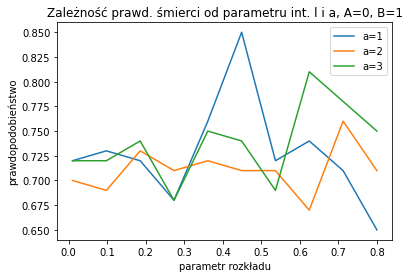

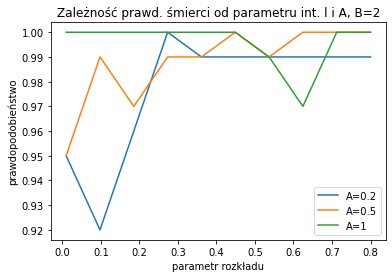

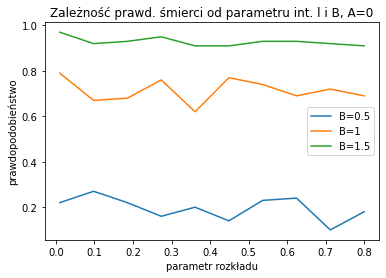

In [ ]:
prob_l()

**Wnioski**

Prawdopodobieństwa śmierci pijaka są bardzo wysokie.

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej 
aut jadących z prawej strony oraz parametrów rozkładów a, A oraz B.  $Z_i∼N(0,a)$ ,  $V_i∼N(A, B)$. Zmienna mieszająca dla aut jadących z lewej strony pochodzi z rozkładu $Exp(0.03)$.

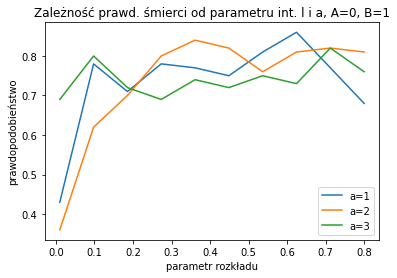

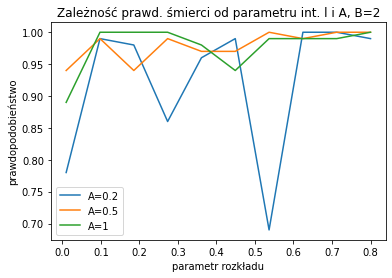

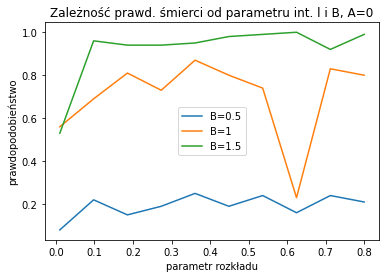

In [ ]:
prob_r()

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej 
aut jadących z lewej strony oraz parametrów rozkładów a, A oraz B.  $Z_i∼Exp(a)$ ,  $V_i∼U(A, B)$. Zmienna mieszająca dla aut jadących z prawej strony pochodzi z rozkładu $Exp(0.03)$.

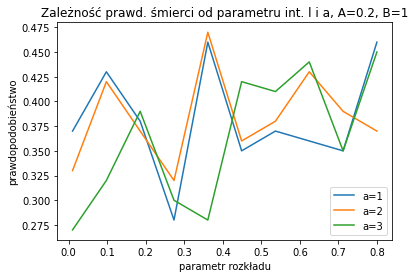

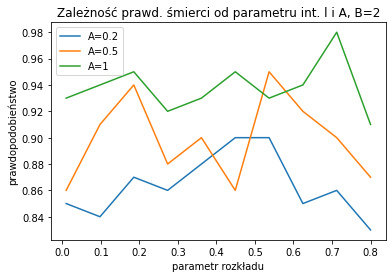

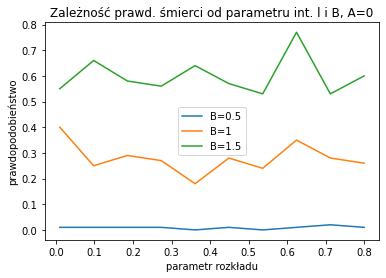

In [ ]:
prob_l(Z_dist='Expon', V_dist='Uniform', A_con=0.2)

Auta pojawiają się zgodnie z mieszanym procesem Poissona ze zmienną mieszającą z rozkładu gamma.



Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej 
aut jadących z lewej strony oraz parametrów rozkładów a, A oraz B.  $Z_i∼N(0,a)$ ,  $V_i∼N(A, B)$. Zmienna mieszająca dla aut jadących z prawej strony pochodzi z rozkładu $G(0.03)$.

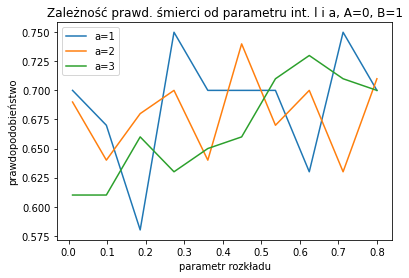

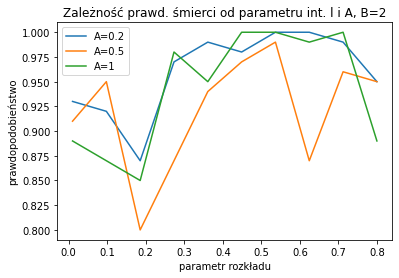

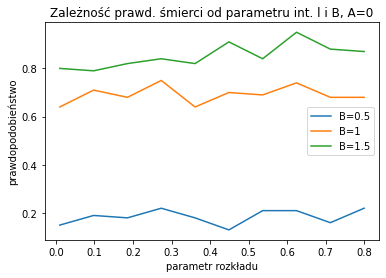

In [ ]:
prob_l(fun_1=np.random.gamma, fun_2=np.random.gamma(0.03))

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej 
aut jadących z prawej strony oraz parametrów rozkładów a, A oraz B.  $Z_i∼N(0,a)$ ,  $V_i∼N(A, B)$. Zmienna mieszająca dla aut jadących z lewej strony pochodzi z rozkładu $G(0.03)$.

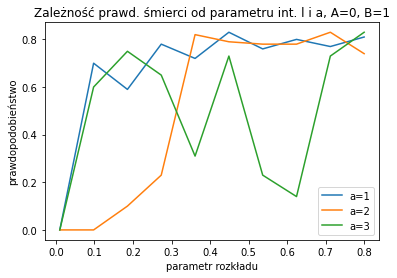

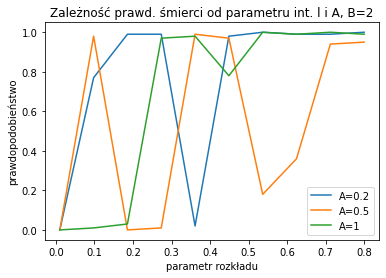

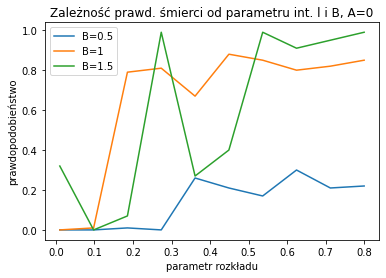

In [ ]:
prob_r(fun_1=np.random.gamma(0.03), fun_2=np.random.gamma)

Występują bardzo gwałtowne skoki.

Zmienną mieszającą dla aut jadących z lewej strony jest zmienna z rozkładu gamma natomiast dla aut jadących z prawej strony zmienna z rozkładu wykładniczego.

Zależność prawdopodobieństwa śmierci od parametru rozkładu zmiennej mieszającej 
aut jadących z lewej strony oraz parametrów rozkładów a i A.  $Z_i∼U(0,a)$ ,  $V_i∼Exp(A)$. Zmienna mieszająca dla aut jadących zprawej strony pochodzi z rozkładu $G(0.03)$.

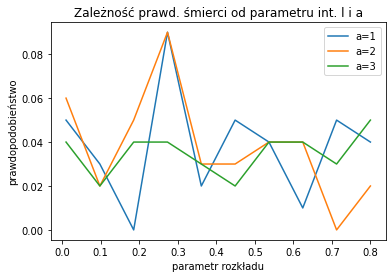

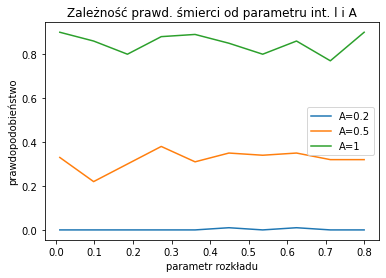

In [ ]:
prob_l(fun_1=np.random.gamma, Z_dist='Uniform', V_dist='Expon', A_con=0.3)

**Wnioski**

Badany problem ma wiele zmiennych i może być badany na wielu płaszczyznach. Powyżej przedstawiłyśmy tylko kilka przykładów i zależności.